In [13]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer
from pytorchcv.model_provider import get_model

class OriDualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,backbone="xception_net", version="cross_attention-spatial-cat",weight=0.5,freeze=0):  
        super(OriDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.backbone = backbone
        self.spatial_extractor = self.get_feature_extractor(freeze=freeze, architecture=backbone, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(freeze=freeze, architecture=backbone, num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="xception_net", freeze=0, pretrained=True, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', pretrained=True, num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            if freeze:
            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                print("Here")
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - 3:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        print("in scale dot.")
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        print('q after: ', q)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        print("attn: ", attn)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        print("q before scaledot: ", spatials)
        print("k before scaledot: ", ifreqs)
        print("v before scaledot: ", ifreqs)
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.spatial_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.spatial_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        # print(frequency_imgs)
        spatial_features, freq_features = self.extract_feature(spatial_imgs, frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        # return spatial_features, freq_features, ifreq_features
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        print("1: ", spatial_vectors)
        print("2: ", ifreq_vectors)
        print("3: ", ifreq_vectors)
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            print("Attn weights: \n", attn_outputs, attn_weights)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        print("Fusion out: \n", out)
        print("Embed: ", embed)
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        print("x before scaledot: ", q)
        print("y before scaledot: ", k)
        print("z before scaledot: ", v)
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        print("in scale dot.")
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        print('q after: ', q)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        print("attn: ", attn)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class MyDualEfficientViT(nn.Module):
    def __init__(self, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft=True,\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_linear="xavier", init_layernorm="normal", init_conv="kaiming"):  
        super(MyDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)
        self.normalize = nn.BatchNorm2d(num_features=self.out_ext_channels) if normalize_ifft else nn.Identity()
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Number of vectors:
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        # Embed vị trí cho từng vectors (nếu chia theo patch):
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vecs+1, self.dim))
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        # self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        ifreq_feature = self.normalize(ifreq_feature)
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features)
        # return rgb_features, freq_features, ifreq_features
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        # print("1: ", rgb_query_vectors)
        # print("2: ", ifreq_key_vectors)
        # print("3: ", ifreq_value_vectors)
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)

        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        print("Fusion: \n", fusion_out)
        print("embed: ", embed)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, in_dim+1, dim)
        if self.position_embed:
            x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x.mean(dim = 1) if self.pool == 'mean' else x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    torch.manual_seed(0)
    x = torch.ones(1, 3, 128, 128)
    y = torch.ones(1, 1, 128, 128)
    model_1 = MyDualEfficientViT( image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                                backbone='xception_net', pretrained=True,\
                                normalize_ifft=False,\
                                flatten_type='patch',\
                                conv_attn=False, ratio=1, qkv_embed=False, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='none',\
                                patch_size=1, position_embed=True, pool='cls',\
                                version='ca-fadd-0.8', unfreeze_blocks=-1)
    # model_1.eval()
    # with torch.no_grad():
    #     print("Model 1")
    #     rgb_1, freq_1, ifreq_1 = model_1(x, y)
    #     print("************************************* RGB 1 ***")
    #     # print(freq_1)
    #     import numpy as np


    # model_2 = OriDualEfficientViT(channels=2048, image_size=128, num_classes=1, dim=1024,\
    #                             depth=6, heads=8, mlp_dim=2048,\
    #                             dim_head=64, dropout=0.15, emb_dropout=0.15,\
    #                             patch_size=1, backbone="xception_net", version='cross_attention-freq-add', weight=0.8, freeze=0)
    # model_2.eval()
    # with torch.no_grad():
    #     print("Model 2")
    #     rgb_2, freq_2, ifreq_2 = model_2(x, y)
    #     print("************************************* RGB 2 ***")
    #     print(freq_2)

    # if torch.equal(rgb_1, rgb_2):
    #     print("Equal rgb")
    # if torch.equal(freq_1, freq_2):
    #     print("Equal freq")
    # if torch.equal(ifreq_1, ifreq_2):
    #     print("Equal ifreq")
    extractor = []
    rest = []
    for name, param in model_1.named_parameters():
        if 'extractor' in name:
            extractor.append(param)
        else:
            rest.append(param)

    from torch.optim import Adam
    optim = Adam(
        [
            {"params": extractor, "lr": 1e-3},
            {"params": rest, "lr": 1e-4},
        ],
    )
    print("lr = ", [optim.param_groups[i]['lr'] for i in range(len(optim.param_groups))])

Pretrained backbone:  True
Pretrained backbone:  True
lr =  [0.001, 0.0001]


In [ ]:


import os.path as osp
file = "/inspect/61dfdc/train/fold_0.txt"
prefix_old 




In [13]:
import torch
import torch.nn.functional as F
from model.vision_transformer.dual_cnn_vit.pairwise_dual_cnn_vit import PairwiseDualCNNViT

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self,device, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.device = device

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        print("output1: ", torch.norm(output1))
        print("euclidean_distance: ", euclidean_distance)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.max(torch.tensor(0.0).to(self.device), torch.pow(torch.tensor(self.margin).to(self.device) - euclidean_distance, 2)))
        return loss_contrastive

# device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# model = PairwiseDualEfficientViT( image_size=128, num_classes=1, dim=1024,\
#                                 depth=6, heads=8, mlp_dim=2048,\
#                                 dim_head=64, dropout=0.15, emb_dropout=0.15,\
#                                 backbone='efficient_net', pretrained=True,\
#                                 normalize_ifft=False,\
#                                 flatten_type='patch',\
#                                 conv_attn=False, ratio=1, qkv_embed=False, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='none',\
#                                 patch_size=1, position_embed=True, pool='cls',\
#                                 version='ca-fadd-0.8', unfreeze_blocks=-1)

# x0, y0 = torch.ones(1, 3, 128, 128), torch.ones(1, 1, 128, 128)
# x1, y1 = torch.ones(1, 3, 128, 128), torch.ones(1, 1, 128, 128)

# mode = model.to(device)
# x0, y0, x1, y1 = x0.to(device), y0.to(device), x1.to(device), y1.to(device)
# em0, out0, em1, out1 = model(x0, y0, x1, y1)
# loss = ContrastiveLoss(device=device, margin=2)
# loss(em0, em1, 0)

torch.manual_seed(0)
x = torch.rand((2, 3))
y = torch.rand((2, 3))

x_magnitude = torch.norm(x, dim=1, keepdim=True)
y_magnitude = torch.norm(y, dim=1, keepdim=True)
max_xy = torch.maximum(x_magnitude, y_magnitude)
euclidean_distance = F.pairwise_distance(x, y, keepdim=True)
norm_euclidean_distance = euclidean_distance / max_xy
print("x = ", x)
print("y = ", y)
print("x mag = ", x_magnitude)
print("y mag = ", y_magnitude)
print("xy max = ", max_xy)
print("euclid = ", euclidean_distance)
print("norm euclid = ", norm_euclidean_distance)





x =  tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]])
y =  tensor([[0.4901, 0.8964, 0.4556],
        [0.6323, 0.3489, 0.4017]])
x mag =  tensor([[0.9188],
        [0.7169]])
y mag =  tensor([[1.1187],
        [0.8264]])
xy max =  tensor([[1.1187],
        [0.8264]])
euclid =  tensor([[0.3889],
        [0.5532]])
norm euclid =  tensor([[0.3477],
        [0.6694]])


In [ ]:
from dataloader.gen_dual_fft import *
import torchvision.transforms as transforms
import torch

image_size=128
transform_test_fwd = transforms.Compose([transforms.Resize((image_size,image_size)),\
                                        transforms.ToTensor(), \
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
transform_fft = transforms.Compose([transforms.ToTensor()])    

fftset = ImageGeneratorDualFFTFeature(path="/mnt/disk1/doan/phucnp/Dataset/UADFV/image/train", image_size=image_size, transform=transform_test_fwd, transform_fft=transform_fft)

fftloader = torch.utils.data.DataLoader(fftset, batch_size=16, num_workers=4, shuffle=True)
from model.vision_transformer.dual_cnn_feedfoward_vit import DualCNNFeedForwardViT

model_ = DualCNNFeedForwardViT(  image_size=128, num_classes=1, dim=1024,\
                            depth=6, heads=8, mlp_dim=2048,\
                            dim_head=64, dropout=0.15, emb_dropout=0.15,\
                            backbone='xception_net', pretrained=False, unfreeze_blocks=-1,\
                            conv_reduction_channels=False, ratio_reduction=1,\
                            flatten_type='patch', patch_size=2,\
                            input_freq_dim=88, hidden_freq_dim=256,\
                            position_embed=False, pool='cls',\
                            aggregation="cat-0.8",\
                            init_weight=False, init_linear="xavier", init_layernorm="norm", init_conv="kaiming")

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model_ = model_.to(device)
for imgs, ffts, labels in fftloader:
    imgs, ffts = imgs.float().to(device), ffts.float().to(device)
    out = model_(imgs, ffts)
    print(out)
    break

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from dataloader.transform import AddGaussianNoise
import os.path as osp
import os


for img_path in os.listdir("/mnt/disk1/doan/phucnp/Dataset/df_in_the_wildv4/image/test/0_real/")[:10]:
    img = Image.open(osp.join("/mnt/disk1/doan/phucnp/Dataset/df_in_the_wildv4/image/test/0_real/", img_path))
    plt.figure(figsize=(30, 50))
    plt.subplot(10, 2, 1)
    plt.imshow(img)
    # plt.show()
    img = transform(img)
    # print(img.shape)
    plt.subplot(10, 2, 2)
    plt.imshow(img)
    plt.show()

In [7]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model
from model.backbone.efficient_net.utils import Conv2dStaticSamePadding

class CrossModalAttention(nn.Module):
    """ CMA attention Layer"""

    def __init__(self, in_dim, activation=None, ratio=8, cross_value=True, gamma_cma=-1):
        super().__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.cross_value = cross_value

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        if gamma_cma == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_cma

        self.softmax = nn.Softmax(dim=-1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        B, C, H, W = x.size()

        proj_query = self.query_conv(x).view(
            B, -1, H*W).permute(0, 2, 1)  # B , HW, C
        proj_key = self.key_conv(y).view(
            B, -1, H*W)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # B, HW, HW
        attention = self.softmax(energy)  # BX (N) X (N)
        if self.cross_value:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW
        else:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)

        out = self.gamma*out + x

        if self.activation is not None:
            out = self.activation(out)
        # print("out: ", out.shape)
        return out  # , attention

class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(x)
        _value = self.value_embedding(x)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            y, _ = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            y = y.view(b, out_h, out_w, d_k, height, width)
            y = y.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(y)
            output.append(y)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)

        return self_attention

class MultiHeadedAttentionv2(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x, y):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(y)
        _value = self.value_embedding(y)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            out, attn = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            out = out.view(b, out_h, out_w, d_k, height, width)
            out = out.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(attn)
            output.append(out)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)
        return self_attention

class FeedForward2D(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channel, out_channel, kernel_size=3, padding=2, dilation=2
            ),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class PatchTrans(nn.Module):
    def __init__(self, in_channel, in_size, patch_resolution="1-2-4-8"):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlock(patchsize, in_channel=in_channel)
        # print(in_channel)

    def forward(self, enc_feat):
        output = self.transform_(enc_feat)
        return output

class TransformerBlock(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256):
        super().__init__()
        self.attention = MultiHeadedAttention(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )

    def forward(self, rgb):
        self_attention = self.attention(rgb)
        output = rgb + self_attention
        output = output + self.feed_forward(output)
        return output

class TransformerBlockv2(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256, gamma_patchtrans=-1):
        super().__init__()
        self.attention = MultiHeadedAttentionv2(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )
        if gamma_patchtrans == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_patchtrans

    def forward(self, rgb, freq):
        self_attention = self.attention(rgb, freq)
        output = rgb + self.gamma * self_attention
        output = output + self.feed_forward(output)
        return output

class PatchTransv2(nn.Module):
    def __init__(self, in_channel, in_size, patch_crossattn_resolution="1-2-4-8", gamma_patchtrans=-1):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_crossattn_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlockv2(patchsize, in_channel=in_channel, gamma_patchtrans=gamma_patchtrans)
        # print(in_channel)

    def forward(self, rgb_fea, freq_fea):
        output = self.transform_(rgb_fea, freq_fea)
        return output

class DualPatchCNNCMAViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, depth_block4=2, \
                backbone='xception_net', pretrained=True, unfreeze_blocks=-1, \
                normalize_ifft='batchnorm',\
                act='none',\
                init_type="xavier_uniform", \
                gamma_cma=-1, gamma_patchtrans=-1, patch_crossattn_resolution='1-2', \
                flatten_type='patch', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='mlp', in_vit_channels=64):  
        super(DualPatchCNNCMAViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.depth_block4 = depth_block4

        self.depth_vit = depth_vit
        self.dim = dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.flatten_type = flatten_type
        self.patch_size = patch_size

        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 8, 8),
            'xception_net': (2048, 8, 8),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        # self.flatten_type = flatten_type # in ['patch', 'channel']
        # self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        # self.position_embed = position_embed
        # self.pool = pool
        # self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels if classifier == 'mlp' else 320)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################

        # self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)
        device = torch.device('cpu')
        self.cma = CrossModalAttention(in_dim=self.out_ext_channels if classifier=='mlp' else 320, activation=self.activation, ratio=4, cross_value=True, gamma_cma=gamma_cma).to(device)

        # Thêm 1 embedding vector cho classify token:
        # self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        # self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer_block_4 = nn.ModuleList([])
        for _ in range(depth_block4):
            self.transformer_block_4.append(PatchTrans(in_channel=40, in_size=16, patch_resolution='1-2-4-8').to(device))
        self.transformer_block_10_rgb = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_patchtrans).to(device)
        self.transformer_block_10_freq = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_patchtrans).to(device)

        # Classifier:
        self.classifier = classifier
        if self.classifier == 'mlp':
            self.mlp_head = nn.Sequential(
                nn.Dropout(dropout_in_mlp),
                nn.Linear(1280, self.mlp_dim),
                nn.ReLU(),
                nn.Dropout(dropout_in_mlp),
                nn.Linear(self.mlp_dim, self.num_classes)
            )
        if self.classifier == 'vit':
            self.convr = nn.Conv2d(in_channels=320, out_channels=in_vit_channels, kernel_size=1)
            self.embedding = nn.Linear(self.patch_size*self.patch_size *in_vit_channels if flatten_type=='patch' else 16, self.dim)
            self.dropout = nn.Dropout(self.emb_dropout)
            self.transformer = Transformer(self.dim, self.depth_vit, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.mlp_dropout = nn.Dropout(dropout_in_mlp)
            self.mlp_hidden = nn.Linear(self.dim, self.mlp_dim)
            self.mlp_relu = nn.ReLU()
            self.mlp_out = nn.Linear(self.mlp_dim, self.num_classes)
            self.mlp_head = nn.Sequential(
                nn.Dropout(dropout_in_mlp),
                nn.Linear(self.dim, self.mlp_dim),
                nn.ReLU(),
                nn.Dropout(dropout_in_mlp),
                nn.Linear(self.mlp_dim, self.num_classes)
            )

        self.sigmoid = nn.Sigmoid()
        # self.init_weights(init_type=init_type)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'leakyrelu':
            activation = nn.LeakyReLU(0.01, inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'selu':
            activation = nn.SELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            # extractor._blocks[11]._depthwise_conv = Conv2dStaticSamePadding(in_channels=672, out_channels=672, kernel_size=(5, 5), stride=(1, 1), groups=672, image_size=224)
            # extractor._conv_head = nn.Identity()
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
            # print(extractor)
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if classname.find('InstanceNorm2d') != -1:
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight.data, 1.0)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
            elif hasattr(m, 'weight') and (
                classname.find('Conv') != -1 or classname.find('Linear') != -1
            ):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight.data, gain=1.0)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)
                elif init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    raise NotImplementedError(
                        'initialization method [%s] is not implemented'
                        % init_type
                    )
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)

        for m in self.children():
            if hasattr(m, 'init_weights'):
                m.init_weights(init_type, gain)

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        return ifreq_feature

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            #
            rgb_features = self.rgb_extractor.extract_features_block_4(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            for attn in self.transformer_block_4:
                rgb_features = attn(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_4(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            #
            rgb_features = self.rgb_extractor.extract_features_block_11(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_11(freq_features)
            rgb_features_1 = self.transformer_block_10_rgb(rgb_features, freq_features)
            freq_features_1 = self.transformer_block_10_freq(freq_features, rgb_features)
            rgb_features = self.rgb_extractor.extract_features_last_block(rgb_features_1, classifier=self.classifier)
            freq_features = self.freq_extractor.extract_features_last_block(freq_features_1, classifier=self.classifier)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)
        out = self.cma(rgb_features, ifreq_features, freq_features)

        if self.classifier == 'mlp':
            x = F.adaptive_avg_pool2d(out, (1, 1))
            x = x.squeeze().squeeze()
            x = self.mlp_head(x)

        if self.classifier == 'vit':
            x = self.convr(out)
            # print(x.shape)
            x = self.flatten_to_vectors(x)
            x = self.embedding(x)
            # print(x.shape)
            x = self.dropout(x)
            x = self.transformer(x)
            x = x.mean(dim = 1)
            x = self.mlp_dropout(x)
            x = self.mlp_hidden(x)
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_out(x)
        return self.sigmoid(x)

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualPatchCNNCMAViT(image_size=128, num_classes=1, depth_block4=2,\
                backbone='efficient_net', pretrained=True, unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                act='selu',\
                init_type="xavier_uniform",\
                gamma_cma=-1, gamma_patchtrans=-1, patch_crossattn_resolution='1-2',\
                flatten_type='patch', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='vit', in_vit_channels=64)
    out = model_(x, y)
    print(out.shape)
    # summary(model_, [(3, 128, 128), (1, 128, 128)], batch_size=32, device='cpu')

Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
torch.Size([32, 1])


In [11]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model
from model.backbone.efficient_net.utils import Conv2dStaticSamePadding

class CrossModalAttention(nn.Module):
    """ CMA attention Layer"""

    def __init__(self, in_dim, activation=None, ratio=8, cross_value=True, gamma_cma=-1):
        super().__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.cross_value = cross_value

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        if gamma_cma == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_cma

        self.softmax = nn.Softmax(dim=-1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        B, C, H, W = x.size()

        proj_query = self.query_conv(x).view(
            B, -1, H*W).permute(0, 2, 1)  # B , HW, C
        proj_key = self.key_conv(y).view(
            B, -1, H*W)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # B, HW, HW
        attention = self.softmax(energy)  # BX (N) X (N)
        if self.cross_value:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW
        else:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)

        out = self.gamma*out + x

        if self.activation is not None:
            out = self.activation(out)
        # print("out: ", out.shape)
        return out  # , attention

class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(x)
        _value = self.value_embedding(x)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            y, _ = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            y = y.view(b, out_h, out_w, d_k, height, width)
            y = y.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(y)
            output.append(y)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)

        return self_attention

class MultiHeadedAttentionv2(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x, y):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(y)
        _value = self.value_embedding(y)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            out, attn = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            out = out.view(b, out_h, out_w, d_k, height, width)
            out = out.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(attn)
            output.append(out)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)
        return self_attention

class FeedForward2D(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channel, out_channel, kernel_size=3, padding=2, dilation=2
            ),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class PatchTrans(nn.Module):
    def __init__(self, in_channel, in_size, patch_resolution="1-2-4-8"):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlock(patchsize, in_channel=in_channel)
        # print(in_channel)

    def forward(self, enc_feat):
        output = self.transform_(enc_feat)
        return output

class TransformerBlock(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256):
        super().__init__()
        self.attention = MultiHeadedAttention(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )

    def forward(self, rgb):
        self_attention = self.attention(rgb)
        output = rgb + self_attention
        output = output + self.feed_forward(output)
        return output

class TransformerBlockv2(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256, gamma_patchtrans=-1):
        super().__init__()
        self.attention = MultiHeadedAttentionv2(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )
        if gamma_patchtrans == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_patchtrans

    def forward(self, rgb, freq):
        self_attention = self.attention(rgb, freq)
        output = rgb + self.gamma * self_attention
        output = output + self.feed_forward(output)
        return output

class PatchTransv2(nn.Module):
    def __init__(self, in_channel, in_size, patch_crossattn_resolution="1-2-4-8", gamma_patchtrans=-1):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_crossattn_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlockv2(patchsize, in_channel=in_channel, gamma_patchtrans=gamma_patchtrans)
        # print(in_channel)

    def forward(self, rgb_fea, freq_fea):
        output = self.transform_(rgb_fea, freq_fea)
        return output

class PairwiseDualPatchCNNCMAViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, depth_block4=2, \
                backbone='xception_net', pretrained=True, unfreeze_blocks=-1, \
                normalize_ifft='batchnorm',\
                act='none',\
                init_type="xavier_uniform", \
                gamma_cma=-1, flatten_type='patch', gamma_patchtrans=0.3, patch_crossattn_resolution='1-2', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='mlp', in_vit_channels=64, embedding_return='mlp_out'):  
        super(PairwiseDualPatchCNNCMAViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.depth_block4 = depth_block4

        self.depth_vit = depth_vit
        self.dim = dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.flatten_type = flatten_type
        self.patch_size = patch_size

        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 8, 8),
            'xception_net': (2048, 8, 8),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        # self.flatten_type = flatten_type # in ['patch', 'channel']
        # self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        # self.position_embed = position_embed
        # self.pool = pool
        # self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels if classifier == 'mlp' else 320)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################

        # self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)
        device = torch.device('cpu')
        self.cma = CrossModalAttention(in_dim=self.out_ext_channels if classifier=='mlp' else 320, activation=self.activation, ratio=4, cross_value=True, gamma_cma=gamma_cma).to(device)

        # Thêm 1 embedding vector cho classify token:
        # self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        # self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer_block_4 = nn.ModuleList([])
        for _ in range(depth_block4):
            self.transformer_block_4.append(PatchTrans(in_channel=40, in_size=16, patch_resolution='1-2-4-8').to(device))
        self.transformer_block_10_rgb = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_patchtrans).to(device)
        self.transformer_block_10_freq = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_patchtrans).to(device)
        self.embedding_return = embedding_return

        # Classifier:
        self.classifier = classifier
        if self.classifier == 'mlp':
            self.mlp_dropout = nn.Dropout(dropout_in_mlp)
            self.mlp_hidden = nn.Linear(self.dim, self.mlp_dim)
            self.mlp_relu = nn.ReLU()
            self.mlp_out = nn.Linear(self.mlp_dim, self.num_classes)

        if self.classifier == 'vit':
            self.convr = nn.Conv2d(in_channels=320, out_channels=in_vit_channels, kernel_size=1)
            self.embedding = nn.Linear(self.patch_size*self.patch_size *in_vit_channels if flatten_type=='patch' else 16, self.dim)
            self.dropout = nn.Dropout(self.emb_dropout)
            self.transformer = Transformer(self.dim, self.depth_vit, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.mlp_dropout = nn.Dropout(dropout_in_mlp)
            self.mlp_hidden = nn.Linear(self.dim, self.mlp_dim)
            self.mlp_relu = nn.ReLU()
            self.mlp_out = nn.Linear(self.mlp_dim, self.num_classes)

        self.sigmoid = nn.Sigmoid()
        # self.init_weights(init_type=init_type)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'leakyrelu':
            activation = nn.LeakyReLU(0.01, inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'selu':
            activation = nn.SELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            # extractor._blocks[11]._depthwise_conv = Conv2dStaticSamePadding(in_channels=672, out_channels=672, kernel_size=(5, 5), stride=(1, 1), groups=672, image_size=224)
            # extractor._conv_head = nn.Identity()
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
            # print(extractor)
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if classname.find('InstanceNorm2d') != -1:
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight.data, 1.0)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
            elif hasattr(m, 'weight') and (
                classname.find('Conv') != -1 or classname.find('Linear') != -1
            ):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight.data, gain=1.0)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)
                elif init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    raise NotImplementedError(
                        'initialization method [%s] is not implemented'
                        % init_type
                    )
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)

        for m in self.children():
            if hasattr(m, 'init_weights'):
                m.init_weights(init_type, gain)

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        return ifreq_feature

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            #
            rgb_features = self.rgb_extractor.extract_features_block_4(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            for attn in self.transformer_block_4:
                rgb_features = attn(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_4(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            #
            rgb_features = self.rgb_extractor.extract_features_block_11(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_11(freq_features)
            rgb_features_1 = self.transformer_block_10_rgb(rgb_features, freq_features)
            freq_features_1 = self.transformer_block_10_freq(freq_features, rgb_features)
            rgb_features = self.rgb_extractor.extract_features_last_block(rgb_features_1, classifier=self.classifier)
            freq_features = self.freq_extractor.extract_features_last_block(freq_features_1, classifier=self.classifier)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)
        out = self.cma(rgb_features, ifreq_features, freq_features)

        if self.classifier == 'mlp':
            x = F.adaptive_avg_pool2d(out, (1, 1))
            x = x.squeeze().squeeze()
            x = self.mlp_dropout(x)
            y = self.mlp_hidden(x)
            x = self.mlp_relu(y)
            x = self.mlp_dropout(x)
            z = self.mlp_out(x)

        if self.classifier == 'vit':
            x = self.convr(out)
            # print(x.shape)
            x = self.flatten_to_vectors(x)
            x = self.embedding(x)
            # print(x.shape)
            x = self.dropout(x)
            x = self.transformer(x)
            x = x.mean(dim = 1)
            x = self.mlp_dropout(x)
            y = self.mlp_hidden(x)
            x = self.mlp_relu(y)
            x = self.mlp_dropout(x)
            z = self.mlp_out(x)
        return y if self.embedding_return == 'mlp_hidden' else z, self.sigmoid(x)

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding0, out0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding1, out1 = self.forward_once(rgb_imgs1, freq_imgs1)
        return embedding0, out0, embedding1, out1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualPatchCNNCMAViT(image_size=128, num_classes=1, depth_block4=2, \
                backbone='efficient_net', pretrained=True, unfreeze_blocks=-1, \
                normalize_ifft='batchnorm',\
                act='selu',\
                init_type="xavier_uniform", \
                gamma_cma=-1, gamma_patchtrans=-1, patch_crossattn_resolution='1-2',\
                flatten_type='patch', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='vit', in_vit_channels=64, embedding_return='mlp_out')
    out, out1, out2, ou3 = model_(x, y, x, y)
    print(out.shape)
    # summary(model_, [(3, 128, 128), (1, 128, 128)], batch_size=32, device='cpu')

Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
torch.Size([32, 1])


In [13]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import Transformer
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class PairwiseDualCNNViT(nn.Module):
    def __init__(self, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft=True,\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-rmifft-fcat-0.5', unfreeze_blocks=-1, \
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, embedding_return='mlp_out'):  
        super(PairwiseDualCNNViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Number of vectors:
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        # Embed vị trí cho từng vectors (nếu chia theo patch):
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vecs+1, self.dim))
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.embedding_return = embedding_return
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        self.to_cls_token = nn.Identity()
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)

        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrelu':
            activation = nn.LeakyReLU(inplace=True)
        elif act == 'selu':
            activation = nn.SELU(inplace=True)
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = nn.BatchNorm2d(num_features=self.out_ext_channels)(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        # print(out.shape)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, in_dim+1, dim)
        if self.position_embed:
            x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x.mean(dim = 1) if self.pool == 'mean' else x[:, 0])
        x = self.mlp_dropout(x)
        y = self.mlp_head_hidden(x)
        x = F.relu(y)
        x = self.mlp_dropout(x)
        z = self.mlp_head_out(x)
        out = self.sigmoid(z)
        return y if self.embedding_return=='mlp_hidden' else z, out

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualCNNViT(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                                backbone='xception_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                conv_attn=True, ratio=8, qkv_embed=True, inner_ca_dim=0, init_ca_weight=True, prj_out=False, act='none',\
                                patch_size=1, position_embed=False, pool='cls',\
                                version='ca-fcat-0.5', unfreeze_blocks=-1, embedding_return='mlp_out')
    out, a, b, c = model_(x, y, x, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
torch.Size([32, 1])


In [20]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class DualCNNViTTest(nn.Module):
    def __init__(self, gpu_id=-1, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, classifier='mlp'):  
        super(DualCNNViTTest, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Number of vectors:
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        # Embed vị trí cho từng vectors (nếu chia theo patch):
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vecs+1, self.dim))
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.mlp_head = nn.Sequential(
            nn.Dropout(dropout_in_mlp),
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout_in_mlp),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_head(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_head(x)

        if self.classifier == 'vit_aggregate_0.3':
            x = self.transformer(embed)
            gamma = float(self.classifier.split('_')[-1])
            x = embed + gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualCNNViTTest(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='xception_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                conv_attn=True, ratio=8, qkv_embed=True, inner_ca_dim=0, init_ca_weight=True, prj_out=False, act='none',\
                                patch_size=1, position_embed=False, pool='cls',\
                                version='ca-fcat-0.5', unfreeze_blocks=-1, classifier='vit_aggregate_0.3')
    out = model_(x, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
torch.Size([32, 1])


In [17]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model
from model.backbone.efficient_net.utils import Conv2dStaticSamePadding

class CrossModalAttention(nn.Module):
    """ CMA attention Layer"""

    def __init__(self, in_dim, activation=None, ratio=8, cross_value=True, gamma_cma=-1):
        super().__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.cross_value = cross_value

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//ratio, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        if gamma_cma == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_cma

        self.softmax = nn.Softmax(dim=-1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        B, C, H, W = x.size()

        proj_query = self.query_conv(x).view(
            B, -1, H*W).permute(0, 2, 1)  # B , HW, C
        proj_key = self.key_conv(y).view(
            B, -1, H*W)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # B, HW, HW
        attention = self.softmax(energy)  # BX (N) X (N)
        if self.cross_value:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW
        else:
            proj_value = self.value_conv(z).view(
                B, -1, H*W)  # B , C , HW

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)

        out = self.gamma*out + x

        if self.activation is not None:
            out = self.activation(out)
        # print("out: ", out.shape)
        return out  # , attention

class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(x)
        _value = self.value_embedding(x)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            y, _ = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            y = y.view(b, out_h, out_w, d_k, height, width)
            y = y.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(y)
            output.append(y)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)

        return self_attention

class MultiHeadedAttentionv2(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, patchsize, d_model):
        super().__init__()
        self.patchsize = patchsize
        self.query_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.value_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.key_embedding = nn.Conv2d(
            d_model, d_model, kernel_size=1, padding=0
        )
        self.output_linear = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def attention(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            query.size(-1)
        )
        p_attn = F.softmax(scores, dim=-1)
        p_val = torch.matmul(p_attn, value)
        return p_val, p_attn

    def forward(self, x, y):
        b, c, h, w = x.size()   # 32, 1280, 8, 8
        # print("x size:", x.size())
        d_k = c // len(self.patchsize)  # 320
        output = []
        _query = self.query_embedding(x)
        _key = self.key_embedding(y)
        _value = self.value_embedding(y)
        attentions = []
        # print("_query: ", _query.shape)
        for (width, height), query, key, value in zip(
            self.patchsize,
            torch.chunk(_query, len(self.patchsize), dim=1),
            torch.chunk(_key, len(self.patchsize), dim=1),
            torch.chunk(_value, len(self.patchsize), dim=1),
        ):
            # print('query: ', query.shape)   # (B, )
            out_w, out_h = w // width, h // height

            # 1) embedding and reshape
            query = query.view(b, d_k, out_h, height, out_w, width)
            query = (
                query.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            key = key.view(b, d_k, out_h, height, out_w, width)
            key = (
                key.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )
            value = value.view(b, d_k, out_h, height, out_w, width)
            value = (
                value.permute(0, 2, 4, 1, 3, 5)
                .contiguous()
                .view(b, out_h * out_w, d_k * height * width)
            )

            out, attn = self.attention(query, key, value)

            # 3) "Concat" using a view and apply a final linear.
            out = out.view(b, out_h, out_w, d_k, height, width)
            out = out.permute(0, 3, 1, 4, 2, 5).contiguous().view(b, d_k, h, w)
            attentions.append(attn)
            output.append(out)

        output = torch.cat(output, 1)
        self_attention = self.output_linear(output)
        return self_attention

class FeedForward2D(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channel, out_channel, kernel_size=3, padding=2, dilation=2
            ),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class PatchTrans(nn.Module):
    def __init__(self, in_channel, in_size, patch_self_resolution="1-2-4-8", gamma_self_patchtrans=-1):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_self_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlock(patchsize, in_channel=in_channel, gamma_self_patchtrans=gamma_self_patchtrans)
        # print(in_channel)

    def forward(self, enc_feat):
        output = self.transform_(enc_feat)
        return output

class TransformerBlock(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256, gamma_self_patchtrans=-1):
        super().__init__()
        self.attention = MultiHeadedAttention(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )
        if gamma_self_patchtrans == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_self_patchtrans


    def forward(self, rgb):
        self_attention = self.attention(rgb)
        output = rgb + self.gamma * self_attention
        output = output + self.feed_forward(output)
        return output

class TransformerBlockv2(nn.Module):
    """
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, patchsize, in_channel=256, gamma_patchtrans=-1):
        super().__init__()
        self.attention = MultiHeadedAttentionv2(patchsize, d_model=in_channel)
        self.feed_forward = FeedForward2D(
            in_channel=in_channel, out_channel=in_channel
        )
        if gamma_patchtrans == -1:
            self.gamma = nn.Parameter(torch.zeros(1))
        else:
            self.gamma = gamma_patchtrans

    def forward(self, rgb, freq):
        self_attention = self.attention(rgb, freq)
        output = rgb + self.gamma * self_attention
        output = output + self.feed_forward(output)
        return output

class PatchTransv2(nn.Module):
    def __init__(self, in_channel, in_size, patch_crossattn_resolution="1-2-4-8", gamma_patchtrans=-1):
        super().__init__()
        self.in_size = in_size

        patchsize = []
        reso = map(float, patch_crossattn_resolution.split("-"))
        for r in reso:
            patchsize.append((int(in_size//r), int(in_size//r)))
        # print(patchsize)
        self.transform_ = TransformerBlockv2(patchsize, in_channel=in_channel, gamma_patchtrans=gamma_patchtrans)
        # print(in_channel)

    def forward(self, rgb_fea, freq_fea):
        output = self.transform_(rgb_fea, freq_fea)
        return output

class PairwiseDualPatchCNNCMAViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, depth_block4=2, \
                backbone='xception_net', pretrained=True, unfreeze_blocks=-1, \
                normalize_ifft='batchnorm',\
                act='none',\
                init_type="xavier_uniform", \
                gamma_cma=-1, gamma_crossattn_patchtrans=-1, patch_crossattn_resolution='1-2', \
                gamma_self_patchtrans=-1, patch_self_resolution='1-2', \
                flatten_type='patch', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='mlp', in_vit_channels=64, embedding_return='mlp_hidden'):  
        super(PairwiseDualPatchCNNCMAViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.depth_block4 = depth_block4

        self.depth_vit = depth_vit
        self.dim = dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.flatten_type = flatten_type
        self.patch_size = patch_size

        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 8, 8),
            'xception_net': (2048, 8, 8),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        self.before_vit_channels = self.out_ext_channels if classifier == 'mlp' else 320
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.before_vit_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################

        # self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)
        self.cma = CrossModalAttention(in_dim=self.before_vit_channels, activation=self.activation, ratio=4, cross_value=True, gamma_cma=gamma_cma)

        # Thêm 1 embedding vector cho classify token:
        # self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        # self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer_block_4 = nn.ModuleList([])
        for _ in range(depth_block4):
            self.transformer_block_4.append(PatchTrans(in_channel=40, in_size=16, patch_self_resolution=patch_self_resolution, gamma_self_patchtrans=gamma_self_patchtrans))
        self.transformer_block_10_rgb = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_crossattn_patchtrans)
        self.transformer_block_10_freq = PatchTransv2(in_channel=112, in_size=8, patch_crossattn_resolution=patch_crossattn_resolution, gamma_patchtrans=gamma_crossattn_patchtrans)

        # Classifier:
        self.classifier = classifier
        self.embedding_return = embedding_return
        if 'mlp' in self.classifier:
            self.mlp_relu = nn.ReLU(inplace=True)
            self.mlp_head_hidden = nn.Linear(1280, self.mlp_dim)
            self.mlp_dropout = nn.Dropout(dropout_in_mlp)
            self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)

        if 'vit' in self.classifier:
            self.convr = nn.Conv2d(in_channels=320, out_channels=in_vit_channels, kernel_size=1)
            self.in_dim = self.patch_size*self.patch_size *in_vit_channels if flatten_type=='patch' else 16
            if self.flatten_type == 'channel':
                self.dim = 32
                self.mlp_dim = 64
            self.embedding = nn.Linear(self.in_dim, self.dim)
            self.transformer = Transformer(self.dim, self.depth_vit, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.mlp_relu = nn.ReLU(inplace=True)
            self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
            self.mlp_dropout = nn.Dropout(dropout_in_mlp)
            self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)

        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.sigmoid = nn.Sigmoid()
        # self.init_weights(init_type=init_type)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'leakyrelu':
            activation = nn.LeakyReLU(0.01, inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'selu':
            activation = nn.SELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            # extractor._blocks[11]._depthwise_conv = Conv2dStaticSamePadding(in_channels=672, out_channels=672, kernel_size=(5, 5), stride=(1, 1), groups=672, image_size=224)
            # extractor._conv_head = nn.Identity()
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
            # print(extractor)
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if classname.find('InstanceNorm2d') != -1:
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight.data, 1.0)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
            elif hasattr(m, 'weight') and (
                classname.find('Conv') != -1 or classname.find('Linear') != -1
            ):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight.data, gain=1.0)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)
                elif init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    raise NotImplementedError(
                        'initialization method [%s] is not implemented'
                        % init_type
                    )
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)

        for m in self.children():
            if hasattr(m, 'init_weights'):
                m.init_weights(init_type, gain)

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        return ifreq_feature

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            #
            rgb_features = self.rgb_extractor.extract_features_block_4(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            for attn in self.transformer_block_4:
                rgb_features = attn(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_4(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            #
            rgb_features = self.rgb_extractor.extract_features_block_11(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_11(freq_features)
            rgb_features_1 = self.transformer_block_10_rgb(rgb_features, freq_features)
            freq_features_1 = self.transformer_block_10_freq(freq_features, rgb_features)
            rgb_features = self.rgb_extractor.extract_features_last_block(rgb_features_1, classifier=self.classifier)
            freq_features = self.freq_extractor.extract_features_last_block(freq_features_1, classifier=self.classifier)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)
        out = self.cma(rgb_features, ifreq_features, freq_features)     # B, 1280, 4, 4

        if self.classifier == 'mlp':
            x = F.adaptive_avg_pool2d(out, (1, 1))
            e1 = x.squeeze().squeeze()
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x)
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.convr(out)
            x = self.flatten_to_vectors(x)
            x = self.embedding(x)
            x = self.transformer(x)

            e1 = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x)
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.convr(out)
            x = self.flatten_to_vectors(x)
            embed = self.embedding(x)
            x = self.transformer(embed)
            x = embed + self.gamma * x
            e1 = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x) 

        if self.embedding_return=='mlp_before':
            e = e1
        if self.embedding_return=='mlp_hidden':
            e = e2
        if self.embedding_return=='mlp_out':
            e = e3
        out = self.sigmoid(e3)
        return e, out

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding0, out0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding1, out1 = self.forward_once(rgb_imgs1, freq_imgs1)
        return embedding0, out0, embedding1, out1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualPatchCNNCMAViT(image_size=128, num_classes=1, depth_block4=2,\
                backbone='efficient_net', pretrained=True, unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                act='selu',\
                init_type="xavier_uniform",\
                gamma_cma=-1, gamma_crossattn_patchtrans=-1, patch_crossattn_resolution='1-2',\
                gamma_self_patchtrans=-1, patch_self_resolution='1-2', \
                flatten_type='channel', patch_size=2, \
                dim=1024, depth_vit=2, heads=3, dim_head=64, dropout=0.15, emb_dropout=0.15, mlp_dim=2048, dropout_in_mlp=0.0, \
                classifier='mlp', in_vit_channels=64, embedding_return='mlp_out')
    out1, out2, _, _ = model_(x, y,x, y)
    print(out1.shape)
    print(out2.shape)

Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
torch.Size([32, 1])
torch.Size([32, 1])


In [3]:
import torch

labels = torch.tensor([[1.0], [1.0]])
labels_cpu = labels.cpu().numpy()
new_labels = []
for label in labels_cpu:
    if label[0] == 0:
        new_labels.append([1, 0])
    else:
        new_labels.append([0, 1])
labels = torch.tensor(new_labels)
print(labels.shape)
print(labels)


torch.Size([2, 2])
tensor([[0, 1],
        [0, 1]])


In [6]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class DualCNNViTTest(nn.Module):
    def __init__(self, gpu_id=-1, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, classifier='mlp'):  
        super(DualCNNViTTest, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)
            gamma = float(self.classifier.split('_')[-1])
            x = embed + gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualCNNViTTest(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='xception_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                conv_attn=False, ratio=1, qkv_embed=True, inner_ca_dim=0, init_ca_weight=True, prj_out=False, act='none',\
                                patch_size=1, position_embed=False, pool='cls',\
                                version='ca-fadd-0.8', unfreeze_blocks=-1, classifier='vit')
    out = model_(x, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
torch.Size([32, 1])


In [21]:
# Câu 2: block Text
text =  """ Số thứ tự: ??? \
            Họ tên: ??? \
            Mã sinh viên: ??? \
            Mã lớp: ??? \
            Ngày/tháng/năm sinh:???
        """
# Câu 3:
ngay_sinh = 28
thang_sinh = 10
so_thu_tu = 10
if ngay_sinh % 3 == 0:
    print("Bộ phim tích cực nhất: ???")
elif ngay_sinh % 3 == 1:
    print("Vị trí công việc mong muốn nhất: ???")
else:
    print("Địa điểm du lịch muốn đến nhất: ???")

# Câu 4:
# Điền thông tin vào các biến:
csvfile_path = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/Social_Network_Ads.csv"
user_id = 55
gender = 'Nam'
age = 22
estimate_salary = 1000000
purchased = 1
student_name = 'phuc'

import csv
with open(csvfile_path, 'a', newline='\n') as f:
    f.write('\n')
    writer = csv.writer(f)
    writer.writerow(list(map(str, [user_id, gender, age, estimate_salary, purchased])))

import pandas as pd 
df = pd.read_csv(csvfile_path)
num_record = len(df)
name_list = [student_name[i%4] for i in range(num_record)]
df['Name'] = name_list
df.to_csv(csvfile_path, index=False)

# Câu 5:
num_record = len(df)
num_attribute = df.shape[1]
print("Số lượng bản ghi: ", num_record)
print("Số lượng thuộc tính: ", num_attribute)

# Câu 6:
thang = 5
lucky_number = 2
n = thang%lucky_number
m = ngay_sinh%thang_sinh+so_thu_tu
print("n dòng dữ liệu đầu tiên: ")
print(df.iloc[:n])
print("m dòng dữ liệu cuối cùng: ")
print(df.iloc[-m:])

# Câu 7:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
df['EncodedGender'] = df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

X = df[['EncodedGender', 'Age', 'EstimatedSalary']].values
y = df['Purchased'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ten_bien_dat_theo_yeu_cau = KNeighborsClassifier(n_neighbors=5)
ten_bien_dat_theo_yeu_cau.fit(X_train, y_train)

print("Độ chính xác trên tập test: ", ten_bien_dat_theo_yeu_cau.score(X_test, y_test))

Vị trí công việc mong muốn nhất: ???
Số lượng bản ghi:  405
Số lượng thuộc tính:  6
n dòng dữ liệu đầu tiên: 
    User ID Gender  Age  EstimatedSalary  Purchased Name
0  15624510   Male   19            19000          0    p
m dòng dữ liệu cuối cùng: 
      User ID  Gender  Age  EstimatedSalary  Purchased Name
387  15627220    Male   39            71000          0    c
388  15672330    Male   47            34000          1    p
389  15668521  Female   48            35000          1    h
390  15807837    Male   48            33000          1    u
391  15592570    Male   47            23000          1    c
392  15748589  Female   45            45000          1    p
393  15635893    Male   60            42000          1    h
394  15757632  Female   39            59000          0    u
395  15691863  Female   46            41000          1    c
396  15706071    Male   51            23000          1    p
397  15654296  Female   50            20000          1    h
398  15755018    Male   36   

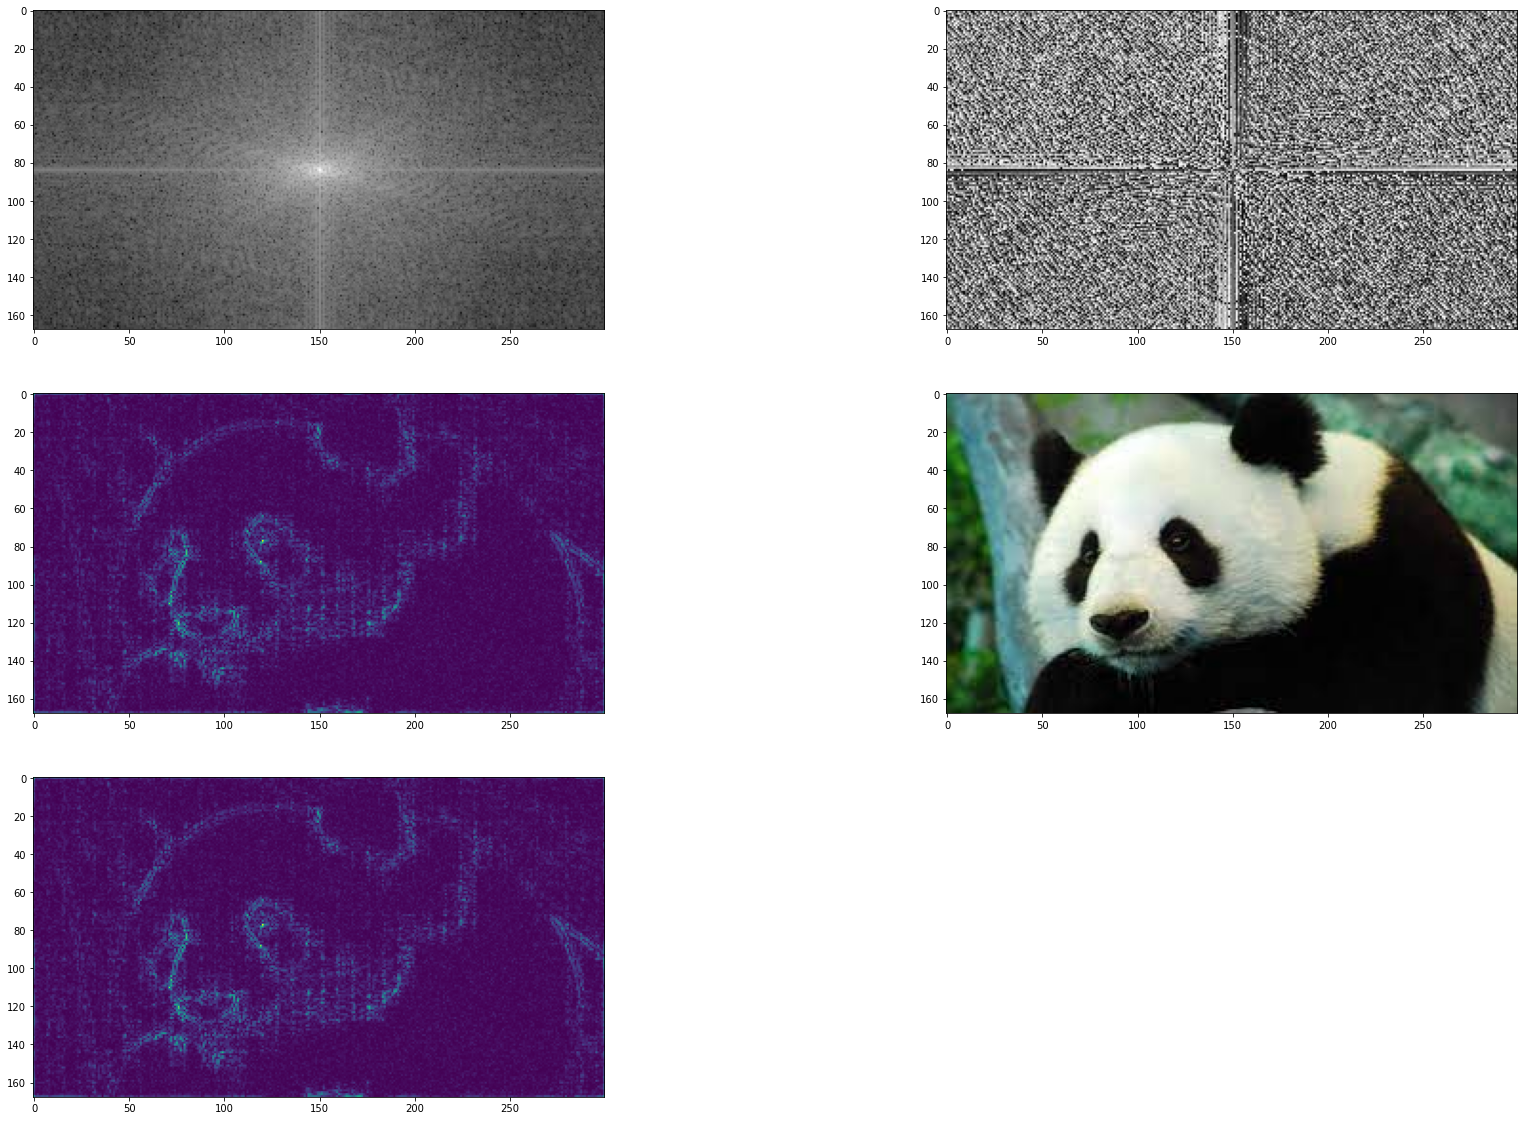

In [35]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

img_path = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/panda.jpg"
img = Image.open(img_path)

imgcv = cv2.imread(img_path)
imgcv = cv2.cvtColor(imgcv, code=cv2.COLOR_BGR2GRAY)
imgcv = np.fft.fftshift(np.fft.fft2(imgcv))
mag = np.log(np.abs(imgcv))
phase = np.angle(imgcv)
# print(phase)

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

plt.figure(figsize=(30, 20))
plt.subplot(3, 2, 1)
plt.imshow(mag, cmap='gray')
plt.subplot(3, 2, 2)
plt.imshow(phase, cmap='gray')
imgconstructed = reconstruct(mag, phase)
# print(imgconstructed)
plt.subplot(3, 2, 3)
plt.imshow(imgconstructed)
plt.subplot(3, 2, 4)
plt.imshow(cv2.imread(img_path))

def reconstruct_torch(mag,ang):
    combined = torch.multiply(mag, torch.exp(1j*ang))
    fftx = torch.fft.ifftshift(combined)
    ffty = torch.fft.ifft2(fftx)
    imgCombined = torch.abs(ffty)
    return imgCombined

mag_torch = torch.tensor(mag).unsqueeze(dim=0)
phase_torch = torch.tensor(phase).unsqueeze(dim=0)
img_rec = reconstruct_torch(mag_torch, phase_torch)
img_rec = img_rec.squeeze(dim=0).numpy().data
plt.subplot(3, 2, 5)
plt.imshow(img_rec)
plt.show()

In [44]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=True, qkv_embed=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

    def forward(self, x, y):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(y)
        else:
            q, k, v = x, y, y
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class TripleCNNViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                freq_combine='add', act='none',\
                patch_size=7, \
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                inner_ca_dim=0, \
                dropout_in_mlp=0.0, classifier='mlp'):  
        super(TripleCNNViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.mag_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)
        self.phase_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)  
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        self.freq_combine = freq_combine
        if self.freq_combine == 'add':
            self.balance_magphase = nn.Parameter(torch.ones(1))
        if self.freq_combine == 'cat':
            self.convfreq = nn.Conv2d(in_channels=2*self.out_ext_channels, out_channels=self.out_ext_channels, kernel_size=1)
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def reconstruct(self, mag_feature, phase_feature, norm_type='none', freq_combine='add'):
        freq_feature = None
        if freq_combine == 'add':
            freq_feature = mag_feature + self.balance_magphase * phase_feature
        if freq_combine == 'cat':
            freq_feature = torch.cat([mag_feature, phase_feature], dim=1)
            freq_feature = self.convfreq(freq_feature)

        combined = torch.multiply(mag_feature, torch.exp(1j*phase_feature))
        fftx = torch.fft.ifftshift(combined)
        ffty = torch.fft.ifft2(fftx)
        reconstructed = torch.abs(ffty)
        if norm_type == 'none':
            ifreq_feature = reconstructed
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(reconstructed)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(reconstructed)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(reconstructed)
        return freq_feature, ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, mag_imgs, phase_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            mag_features = self.mag_extractor.extract_features(mag_imgs)              # shape (batchsize, 1280, 4, 4)
            phase_features = self.phase_extractor.extract_features(phase_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            mag_features = self.mag_extractor(mag_imgs)
            phase_features = self.phase_extractor(phase_imgs)
        return rgb_features, mag_features, phase_features

    def forward(self, rgb_imgs, mag_imgs, phase_imgs):
        rgb_features, mag_features, phase_features = self.extract_feature(rgb_imgs, mag_imgs, phase_imgs)
        freq_features, ifreq_features = self.reconstruct(mag_features, phase_features, norm_type=self.normalize_ifft, freq_combine=self.freq_combine)
        print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_vectors = self.flatten_to_vectors(rgb_features)
        freq_vectors = self.flatten_to_vectors(freq_features)
        ifreq_vectors = self.flatten_to_vectors(ifreq_features)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        _, attn_weight = self.CA(rgb_vectors, ifreq_vectors)
        attn_freq = torch.bmm(attn_weight, freq_vectors)
        fusion_out = self.fusion(rgb_vectors, attn_freq)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)    
            x = embed + self.gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = TripleCNNViT(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='efficient_net', pretrained=False,\
                                normalize_ifft='batchnorm',\
                                flatten_type='patch',\
                                inner_ca_dim=0, freq_combine='add', \
                                patch_size=2, \
                                version='ca-fcat-0.5', unfreeze_blocks=-1, classifier='vit_aggregate_0.3')
    out = model_(x, y, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
Pretrained backbone:  False
Features shape:  torch.Size([32, 1280, 4, 4]) torch.Size([32, 1280, 4, 4]) torch.Size([32, 1280, 4, 4])
torch.Size([32, 1])


In [79]:
import numpy as np
import cv2
import random
from typing import List, Dict
from glob import glob
from tqdm import tqdm
from os.path import join
import os.path as osp

np.random.seed(0)
random.seed(0)

class CustomizeKFold(object):
    def __init__(self, n_folds: int, train_dir: str, val_dir: str, trick=True):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.n_folds = n_folds
        self.trick = trick
        if self.trick:
            if 'dfdc' in train_dir:
                self.do_trick = 'real:5000,fake:2000'
            if 'df_in_the_wild' in train_dir:
                self.do_trick = 'real:4000,fake:2000'
            if 'Celeb-DF' in train_dir:
                self.do_trick = 'real:5000,fake:2000'
            if 'UADFV' in train_dir:
                self.do_trick = 'real:0,fake:0'
            if 'ff' in train_dir:
                self.do_trick = 'real:0,fake:0'

        # Concat train and val
        self.real_paths, self.fake_paths = self.get_path()
        self.real_videos, self.fake_videos = self.extract_video()
        self.real_video_names = list(self.real_videos.keys())
        self.fake_video_names = list(self.fake_videos.keys())
        self.num_real_videos, self.num_fake_videos = len(self.real_video_names), len(self.fake_video_names)
        random.shuffle(self.real_video_names)
        random.shuffle(self.fake_video_names)
        # print("real video: ", self.num_real_videos)
        # print("Sample list real: ", self.real_video_names[0], self.real_video_names[-1])
        # print("Sample list dict real: ", (self.real_video_names[0], self.real_videos[self.real_video_names[0]]), (self.real_video_names[-1], self.real_videos[self.real_video_names[-1]]))
        # print("\nfake video: ", self.num_fake_videos)
        # print("Sample list fake: ", self.fake_video_names[0], self.fake_video_names[-1])
        # print("Sample list dict fake: ", (self.fake_video_names[0], self.fake_videos[self.fake_video_names[0]]), (self.fake_video_names[-1], self.fake_videos[self.fake_video_names[-1]]))


    def get_path(self):
        cls_real = ['0_real']
        cls_fake = ['1_df', '1_f2f', '1_fs', '1_nt', '1_fake']
        real_paths, fake_paths = [], []
        for c in cls_real:
            real_paths.extend(glob(join(self.train_dir, '{}/*'.format(c))))
            real_paths.extend(glob(join(self.val_dir, '{}/*'.format(c))))
        for c in cls_fake:
            fake_paths.extend(glob(join(self.train_dir, '{}/*'.format(c))))
            fake_paths.extend(glob(join(self.val_dir, '{}/*'.format(c))))
        return real_paths, fake_paths

    def extract_video(self):
        """ Return real_videos: {video1: [video1_0, video1_1... video1_n], video2: [video2_0, ... video2_m], ...}
        """
        def extract(paths: List[str]):
            result = {}
            for p in paths:
                info = osp.basename(p).split('_')
                video_name = '_'.join(info[:-1])
                image_idx = info[-1]
                if video_name not in result.keys():
                    result[video_name] = [p]
                else:
                    result[video_name].append(p)
            return result
        real_videos = extract(paths=self.real_paths)
        fake_videos = extract(paths=self.fake_paths)
        return real_videos, fake_videos

    def get_fold(self, fold_idx: int):
        """ Trả về tập train_path, val_path
        """
        # Get fold in real class
        train_real_videos, val_real_videos = self.get_fold_in_cls(fold_idx=fold_idx, cls='real')
        train_real_images, val_real_images = [], []
        for v in train_real_videos:
            train_real_images.extend(self.real_videos[v])
        for v in val_real_videos:
            val_real_images.extend(self.real_videos[v])

        # print("get fold: ")
        # print("train real: ", len(train_real_images))
        # print("val real: ", len(val_real_images))

        # Get fold in fake class
        train_fake_videos, val_fake_videos = self.get_fold_in_cls(fold_idx=fold_idx, cls='fake')
        train_fake_images, val_fake_images = [], []
        for v in train_fake_videos:
            train_fake_images.extend(self.fake_videos[v])
        for v in val_fake_videos:
            val_fake_images.extend(self.fake_videos[v])

        # print("train fake: ", len(train_fake_images))
        # print("val fake: ", len(val_fake_images))
        # trick:
        if self.trick:
            random.shuffle(train_real_images)
            random.shuffle(train_fake_images)
            info = self.do_trick.split(',')
            num_real = int(info[0].split(':')[-1])
            val_real_images.extend(train_real_images[:num_real])
            train_real_images = train_real_images[num_real:]
            num_fake = int(info[1].split(':')[-1])
            val_fake_images.extend(train_fake_images[:num_fake])
            train_fake_images = train_fake_images[num_fake:]
            # print("After do trick")
            # print("train real: ", len(train_real_images))
            # print("val real: ", len(val_real_images))
            # print("train fake: ", len(train_fake_images))
            # print("val fake: ", len(val_fake_images))
            # print("test 10 train images: ")
        # Concatenate:
        train_images = train_real_images + train_fake_images
        val_images = val_real_images + val_fake_images
        # for i in range(10):
        #     print("     ", train_images[i])
        # print("test 10 val images:")
        # for i in range(10):
        #     print("     ", val_images[i])
        return train_images, val_images

    def get_fold_in_cls(self, fold_idx: int, cls='real'):
        if cls == 'real':
            num_samples = self.num_real_videos
            samples = np.array(self.real_video_names, dtype=object)
        else:
            num_samples = self.num_fake_videos
            samples = np.array(self.fake_video_names, dtype=object)
        num_samples_per_fold = num_samples // self.n_folds
        val_idx_from = num_samples_per_fold * fold_idx
        val_idx_to = num_samples_per_fold * (fold_idx + 1) if (fold_idx != self.n_folds - 1) else num_samples
        val = samples[val_idx_from: val_idx_to]
        train = np.concatenate([samples[:val_idx_from], samples[val_idx_to:]])
        return train, val

if __name__ == '__main__':
    customize_kfold = CustomizeKFold(n_folds=5, train_dir='/mnt/disk1/doan/phucnp/Dataset/Celeb-DFv5/image/train', val_dir='/mnt/disk1/doan/phucnp/Dataset/Celeb-DFv5/image/val', trick=True)
    for i in range(5):
        train, val = customize_kfold.get_fold(i)
        print("Fold: ", i)
        print("     train: ", len(train))
        print("     val: ", len(val))

Fold:  0
     train:  170066
     val:  51533
Fold:  1
     train:  170762
     val:  50837
Fold:  2
     train:  170223
     val:  51376
Fold:  3
     train:  170076
     val:  51523
Fold:  4
     train:  170269
     val:  51330


In [85]:
from telnetlib import OUTMRK
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import Transformer
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class PairwiseDualCNNViT(nn.Module):
    def __init__(self, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft=True,\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, version='ca-rmifft-fcat-0.5', unfreeze_blocks=-1, \
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, classifier='vit_aggregate_-1', embedding_return='mlp_out'):  
        super(PairwiseDualCNNViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.embedding_return= embedding_return
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        # print(out.shape)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        e0 = embed.mean(dim = 1).squeeze(dim=1)
        # print(e0.shape)
        if self.classifier == 'mlp':
            e1 = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            e1 = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)    
            x = embed + self.gamma * x
            e1 = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(e1)         
            e2 = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(e2)
            x = self.mlp_dropout(x)
            e3 = self.mlp_head_out(x)
        
        if self.embedding_return=='vit_before':
            e = e0
        if self.embedding_return=='mlp_before':
            e = e1
        if self.embedding_return=='mlp_hidden':
            e = e2
        if self.embedding_return=='mlp_out':
            e = e3
        out = self.sigmoid(e3)
        return e, out

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualCNNViT(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='xception_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                conv_attn=True, ratio=8, qkv_embed=True, inner_ca_dim=0, init_ca_weight=True, prj_out=False, act='none',\
                                patch_size=1, \
                                version='ca-fcat-0.5', unfreeze_blocks=-1, embedding_return='vit_before')
    out = model_(x, y, x, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
torch.Size([32, 1024])
torch.Size([32, 1024])


AttributeError: 'tuple' object has no attribute 'shape'

In [9]:
import torch
import torch.nn.functional as F

class TripletLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        anchor_magnitude = torch.norm(anchor, dim=1, keepdim=True)
        positive_magnitude = torch.norm(positive, dim=1, keepdim=True)
        negative_magnitude = torch.norm(negative, dim=1, keepdim=True)
        max1 = torch.maximum(anchor_magnitude, positive_magnitude)
        max2 = torch.maximum(anchor_magnitude, negative_magnitude)
        #
        pos_dist = F.pairwise_distance(anchor, positive, keepdim=True) / max1
        neg_dist = F.pairwise_distance(anchor, negative, keepdim=True) / max2
        # print(pos_dist, neg_dist)
        triplet_loss = F.relu(pos_dist - neg_dist + self.margin)
        return triplet_loss.mean()

# torch.manual_seed(1)
anchor = torch.rand(32, 1024)
positive = torch.rand(32, 1024)
negative = torch.rand(1, 1024)
tloss = TripletLoss(margin=0.2)
tloss(anchor, positive, negative)


tensor([[0.6845],
        [0.6776],
        [0.6978],
        [0.6790],
        [0.7174],
        [0.6910],
        [0.6909],
        [0.7301],
        [0.6965],
        [0.6920],
        [0.7092],
        [0.6993],
        [0.6935],
        [0.7204],
        [0.7136],
        [0.6609],
        [0.7239],
        [0.7171],
        [0.6907],
        [0.6905],
        [0.6894],
        [0.6951],
        [0.6880],
        [0.7124],
        [0.7102],
        [0.6961],
        [0.7046],
        [0.7052],
        [0.7047],
        [0.7120],
        [0.7214],
        [0.6833]]) tensor([[0.6666],
        [0.6780],
        [0.7160],
        [0.6744],
        [0.6904],
        [0.7004],
        [0.6819],
        [0.7004],
        [0.6714],
        [0.6833],
        [0.7022],
        [0.6885],
        [0.6766],
        [0.6749],
        [0.6905],
        [0.6776],
        [0.7134],
        [0.6804],
        [0.7213],
        [0.6860],
        [0.6990],
        [0.6856],
        [0.6822],
        [

tensor(0.2083)

In [4]:
import numpy as np
import cv2
import random
from typing import List, Dict
from glob import glob
from tqdm import tqdm
from os.path import join
import os.path as osp

np.random.seed(0)
random.seed(0)

class CustomizeKFold(object):
    def __init__(self, n_folds: int, train_dir: str, val_dir: str, trick=True):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.n_folds = n_folds
        self.trick = trick
        if self.trick:
            if 'dfdc' in train_dir:
                self.do_trick = 'real:5000,fake:2000'
            if 'df_in_the_wild' in train_dir:
                self.do_trick = 'real:4000,fake:2000'
            if 'Celeb-DF' in train_dir:
                self.do_trick = 'real:5000,fake:2000'
            if 'UADFV' in train_dir:
                self.do_trick = 'real:0,fake:0'
            if 'ff' in train_dir:
                self.do_trick = 'real:0,fake:0'

        # Concat train and val
        self.real_paths, self.fake_paths = self.get_path()
        self.real_videos, self.fake_videos = self.extract_video()
        self.real_video_names = list(self.real_videos.keys())
        self.fake_video_names = list(self.fake_videos.keys())
        self.num_real_videos, self.num_fake_videos = len(self.real_video_names), len(self.fake_video_names)
        random.shuffle(self.real_video_names)
        random.shuffle(self.fake_video_names)
        # print("real video: ", self.num_real_videos)
        # print("Sample list real: ", self.real_video_names[0], self.real_video_names[-1])
        # print("Sample list dict real: ", (self.real_video_names[0], self.real_videos[self.real_video_names[0]]), (self.real_video_names[-1], self.real_videos[self.real_video_names[-1]]))
        # print("\nfake video: ", self.num_fake_videos)
        # print("Sample list fake: ", self.fake_video_names[0], self.fake_video_names[-1])
        # print("Sample list dict fake: ", (self.fake_video_names[0], self.fake_videos[self.fake_video_names[0]]), (self.fake_video_names[-1], self.fake_videos[self.fake_video_names[-1]]))


    def get_path(self):
        cls_real = ['0_real']
        cls_fake = ['1_df', '1_f2f', '1_fs', '1_nt', '1_fake']
        real_paths, fake_paths = [], []
        for c in cls_real:
            real_paths.extend(glob(join(self.train_dir, '{}/*'.format(c))))
            real_paths.extend(glob(join(self.val_dir, '{}/*'.format(c))))
        for c in cls_fake:
            fake_paths.extend(glob(join(self.train_dir, '{}/*'.format(c))))
            fake_paths.extend(glob(join(self.val_dir, '{}/*'.format(c))))
        return real_paths, fake_paths

    def extract_video(self):
        """ Return real_videos: {video1: [video1_0, video1_1... video1_n], video2: [video2_0, ... video2_m], ...}
        """
        def extract(paths: List[str]):
            result = {}
            for p in paths:
                info = osp.basename(p).split('_')
                video_name = '_'.join(info[:-1])
                image_idx = info[-1]
                if video_name not in result.keys():
                    result[video_name] = [p]
                else:
                    result[video_name].append(p)
            return result
        real_videos = extract(paths=self.real_paths)
        fake_videos = extract(paths=self.fake_paths)
        return real_videos, fake_videos

    def get_fold(self, fold_idx: int):
        """ Trả về tập train_path, val_path
        """
        # Get fold in real class
        train_real_videos, val_real_videos = self.get_fold_in_cls(fold_idx=fold_idx, cls='real')
        train_real_images, val_real_images = [], []
        for v in train_real_videos:
            train_real_images.extend(self.real_videos[v])
        for v in val_real_videos:
            val_real_images.extend(self.real_videos[v])

        # print("get fold: ")
        # print("train real: ", len(train_real_images))
        # print("val real: ", len(val_real_images))

        # Get fold in fake class
        train_fake_videos, val_fake_videos = self.get_fold_in_cls(fold_idx=fold_idx, cls='fake')
        train_fake_images, val_fake_images = [], []
        for v in train_fake_videos:
            train_fake_images.extend(self.fake_videos[v])
        for v in val_fake_videos:
            val_fake_images.extend(self.fake_videos[v])

        # print("train fake: ", len(train_fake_images))
        # print("val fake: ", len(val_fake_images))
        # trick:
        if self.trick:
            random.shuffle(train_real_images)
            random.shuffle(train_fake_images)
            info = self.do_trick.split(',')
            num_real = int(info[0].split(':')[-1])
            val_real_images.extend(train_real_images[:num_real])
            train_real_images = train_real_images[num_real:]
            num_fake = int(info[1].split(':')[-1])
            val_fake_images.extend(train_fake_images[:num_fake])
            train_fake_images = train_fake_images[num_fake:]
            # print("After do trick")
            # print("train real: ", len(train_real_images))
            # print("val real: ", len(val_real_images))
            # print("train fake: ", len(train_fake_images))
            # print("val fake: ", len(val_fake_images))
            # print("test 10 train images: ")
        # Concatenate:
        train_images = train_real_images + train_fake_images
        val_images = val_real_images + val_fake_images
        # for i in range(10):
        #     print("     ", train_images[i])
        # print("test 10 val images:")
        # for i in range(10):
        #     print("     ", val_images[i])
        return train_images, val_images

    def get_fold_in_cls(self, fold_idx: int, cls='real'):
        if cls == 'real':
            num_samples = self.num_real_videos
            samples = np.array(self.real_video_names, dtype=object)
        else:
            num_samples = self.num_fake_videos
            samples = np.array(self.fake_video_names, dtype=object)
        num_samples_per_fold = num_samples // self.n_folds
        val_idx_from = num_samples_per_fold * fold_idx
        val_idx_to = num_samples_per_fold * (fold_idx + 1) if (fold_idx != self.n_folds - 1) else num_samples
        val = samples[val_idx_from: val_idx_to]
        train = np.concatenate([samples[:val_idx_from], samples[val_idx_to:]])
        return train, val

if __name__ == '__main__':
    customize_kfold = CustomizeKFold(n_folds=2, train_dir='/mnt/disk1/doan/phucnp/Dataset/dfdcv5/image/train', val_dir='/mnt/disk1/doan/phucnp/Dataset/dfdcv5/image/val', trick=True)
    for i in range(2):
        train, val = customize_kfold.get_fold(i)
        print("Fold: ", i)
        print("     train: ", len(train))
        print("     val: ", len(val))

Fold:  0
     train:  104510
     val:  118786
Fold:  1
     train:  104786
     val:  118510


In [1]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class DualCNNViTExpe(nn.Module):
    def __init__(self, image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_size=2,\
                version='ca-fcat-0.5',\
                features_at_block='10',\
                dropout_in_mlp=0.0, classifier='mlp'):  

        super(DualCNNViTExpe, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.backbone = backbone

        self.features_size = {
            'efficient_net': {
                '0': (24, 32, 32),
                '2': (40, 16, 16),
                '4': (80, 8, 8),
                '10': (192, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': (2048, 4, 4)
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][features_at_block][1] * self.features_size[backbone][features_at_block][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][features_at_block][1] * self.features_size[backbone][features_at_block][2])

        print("in_dim: ", self.in_dim)
        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=0, prj_out=True, qkv_embed=qkv_embed, init_weight=False)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
                freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            else:
                rgb_features = self.rgb_extractor.extract_features_at_block(rgb_imgs, int(self.features_at_block))
                freq_features = self.freq_extractor.extract_features_at_block(freq_imgs, int(self.features_at_block))
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        rgb_query_vectors = self.flatten_to_vectors(rgb_features)
        freq_value_vectors = self.flatten_to_vectors(freq_features)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_features)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_features)
        print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)    
            x = embed + self.gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualCNNViTExpe(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='efficient_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                qkv_embed=True, prj_out=False, act='none',\
                                patch_size=1, features_at_block='10',\
                                version='ca-fcat-0.5', unfreeze_blocks=-1, classifier='vit_aggregate_0.3')
    out = model_(x, y)
    print(out.shape)
    extractor = model_.rgb_extractor
    for idx in range(16):
        out = extractor.extract_features_at_block(x, idx)
        print("after block {}: ".format(idx), out.shape)

/mnt/disk1/anaconda3/envs/phucnp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pretrained backbone:  False
Pretrained backbone:  False
in_dim:  192
Vectors shape:  torch.Size([32, 16, 192]) torch.Size([32, 16, 192]) torch.Size([32, 16, 192]) torch.Size([32, 16, 192])
torch.Size([32, 1])
after block 0:  torch.Size([32, 24, 32, 32])
after block 1:  torch.Size([32, 24, 32, 32])
after block 2:  torch.Size([32, 40, 16, 16])
after block 3:  torch.Size([32, 40, 16, 16])
after block 4:  torch.Size([32, 80, 8, 8])
after block 5:  torch.Size([32, 80, 8, 8])
after block 6:  torch.Size([32, 80, 8, 8])
after block 7:  torch.Size([32, 112, 8, 8])
after block 8:  torch.Size([32, 112, 8, 8])
after block 9:  torch.Size([32, 112, 8, 8])
after block 10:  torch.Size([32, 192, 4, 4])
after block 11:  torch.Size([32, 192, 4, 4])
after block 12:  torch.Size([32, 192, 4, 4])
after block 13:  torch.Size([32, 192, 4, 4])
after block 14:  torch.Size([32, 320, 4, 4])
after block 15:  torch.Size([32, 320, 4, 4])


In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super(CrossAttention, self).__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1] == 'fcat' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = None
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class MultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8-0.4-0.2-0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(MultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('-')))
        self.gamma = []
        if residual:
            for g in self.gamma_reso:
                if g != -1:
                    self.gamma.append(g)
                else:
                    self.gamma.append(nn.Parameter(torch.ones(1)))

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.patch_dim = [int(in_channels * (p ** 2)) for p in self.patch_size]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
        else:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        for i in range(len(self.patch_size)):
            # Flatten to vectors:
            rgb_vectors = self.flatten_to_vectors(feature=rgb_features, p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freq_features, p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreq_features, p_size=self.patch_size[i])  # B, num_patch, patch_dim
            print("patchsize: ", self.patch_size[i])
            print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
    
class DualCNNViTExpeMultiVit(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8-0.4-0.2-0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10',\
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True):  

        super(DualCNNViTExpeMultiVit, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone

        self.features_size = {
            'efficient_net': {
                '0': (24, 32, 32),
                '1': (24, 32, 32),
                '2': (40, 16, 16),
                '3': (40, 16, 16),
                '4': (80, 8, 8),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (112, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (192, 4, 4),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (320, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])

        self.multi_transformer = MultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
                freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            else:
                rgb_features = self.rgb_extractor.extract_features_at_block(rgb_imgs, int(self.features_at_block))
                freq_features = self.freq_extractor.extract_features_at_block(freq_imgs, int(self.features_at_block))
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        x = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(x)         # B, number_of_patch * D
        x = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(x)
        x = self.mlp_dropout(x)
        x = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualCNNViTExpeMultiVit(image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2', gammaagg_reso='0.8-0.4',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10',\
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True)

    out = model_(x, y)
    print(out.shape)


In [2]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class DAB(nn.Module):
    def __init__(self, n_feat: int, reduction: int, act_dab=None, dab_modules='sa-ca'):
        super(DAB, self).__init__()
        self.use_sa = True if 'sa' in dab_modules else False
        self.use_ca = True if 'ca' in dab_modules else False
        self.dab_modules = dab_modules
        self.SA = spatial_attn_layer() if self.use_sa else None             ## Spatial Attention
        self.CA = CALayer(n_feat, reduction)  if self.use_ca else None      ## Channel Attention
        self.conv1x1_1 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(n_feat, n_feat, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        self.act = act_dab

    def forward(self, ifreq, rgb):
        if self.use_sa:
            sa_branch = self.SA(ifreq)
        if self.use_ca:
            ca_branch = self.CA(ifreq)

        if self.use_sa and self.use_ca:
            attn = torch.cat([sa_branch, ca_branch], dim=1)
        if self.use_sa and not self.use_ca:
            attn = sa_branch
        if not self.use_sa and self.use_ca:
            attn = ca_branch

        if '-' in self.dab_modules:
            attn = self.conv1x1_1(attn)
        else:
            attn = self.conv1x1_2(attn)

        # print("        attn shape: ", rgb.shape, attn.shape)
        res = torch.cat([rgb, attn], dim=1)
        res = self.conv1x1_3(res)
        if self.act:
            res = self.act(res)
        return res

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super().__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1][0] == 'f' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = None
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()
        print("freq combine: ", self.use_freq)

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class MultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8_0.4_0.2_0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(MultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('_')))
        self.gamma = []
        self.g0 = nn.Parameter(torch.ones(1))
        self.g1 = nn.Parameter(torch.ones(1))
        self.g2 = nn.Parameter(torch.ones(1))
        self.g3 = nn.Parameter(torch.ones(1))
        cnt = 0
        if residual:
            for g in self.gamma_reso:
                if g != 0:
                    self.gamma.append(g)
                else:
                    if cnt == 0:
                        self.gamma.append(self.g0)
                    if cnt == 1:
                        self.gamma.append(self.g1)
                    if cnt == 2:
                        self.gamma.append(self.g2)
                    if cnt == 3:
                        self.gamma.append(self.g3)
                    cnt += 1

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.patch_dim = [int(in_channels * (p ** 2)) for p in self.patch_size]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
        else:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        for i in range(len(self.patch_size)):
            # Flatten to vectors:
            rgb_vectors = self.flatten_to_vectors(feature=rgb_features, p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freq_features, p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreq_features, p_size=self.patch_size[i])  # B, num_patch, patch_dim
            # print("patchsize: ", self.patch_size[i])
            # print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            # print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            # print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        # print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
class DualDabCNNMultiViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8_0.4_0.2_0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, \
                act_dab='none', dab_modules='sa-ca', dabifft_normalize='none', dab_blocks='1_3_6_9'):  

        super(DualDabCNNMultiViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone
        if 'efficient_net' in backbone:
            dab_blocks = '-1_' + dab_blocks
        self.dab_blocks = sorted(list(map(int, dab_blocks.split('_'))))
        print("dab blocks: ", self.dab_blocks)
        self.dabifft_normalize = dabifft_normalize
        self.last_block = int(features_at_block) if features_at_block != 'final' else 15

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)
        self.dab_activation = self.get_activation(act_dab)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])
        
        # DAB Block:
        num_dab = len(self.dab_blocks) - 1
        self.dab = nn.ModuleList([])
        for i in range(num_dab):
            at_block = self.dab_blocks[i+1]
            in_features = self.features_size[backbone][str(at_block)][0]
            self.dab.append(DAB(n_feat=in_features, reduction=1, act_dab=self.dab_activation, dab_modules=dab_modules))

        # Multi ViT:
        self.multi_transformer = MultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            # Conv stem:
            rgb_features = self.rgb_extractor.extract_features_convstem(rgb_imgs)                 
            freq_features = self.freq_extractor.extract_features_convstem(freq_imgs)
            # print("Features shape: ", rgb_features.shape)
            # DAB Block:
            for i in range(len(self.dab_blocks) - 1):   # -1_1_3_6_9
                                                        #  0 1 2 3 4
                # print("dab_blocks: ", self.dab_blocks[i]+1, ' -> ', self.dab_blocks[i+1])
                rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                # Attention, concat and reduce channels:
                ifreq_features = self.ifft(freq_features, norm_type=self.dabifft_normalize)
                # print(" Shape: ", rgb_features.shape, ifreq_features.shape)
                rgb_features = self.dab[i](ifreq_features, rgb_features)

            # Last block:
            rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            
            # Convhead:
            # print("After last block Features shape: ", rgb_features.shape, freq_features.shape)
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features_convhead(rgb_features)
                freq_features = self.freq_extractor.extract_features_convhead(freq_features)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        x = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(x)         # B, number_of_patch * D
        x = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(x)
        x = self.mlp_dropout(x)
        x = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(2, 3, 128, 128)
    y = torch.ones(2, 1, 128, 128)
    model_ = DualDabCNNMultiViT(image_size=128, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4', gammaagg_reso='0.8_0.4_0.2',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='11', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, \
                act_dab='none', dab_modules='sa', dabifft_normalize='normal', dab_blocks='0_3_5_6_10')
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
    x, y = x.to(device), y.to(device)
    model_ = model_.to(device)

    # extractor = model_.rgb_extractor
    # print(len(extractor._blocks))
    # for idx in range(17):
    #     print("after block ", idx, " shape: ", extractor.extract_features_at_block(x, selected_block=idx).shape)
    ### CHECK @@@
    # print("\nCheck @@@")
    # for idx in range(16):
    #     print("after block ", idx, " shape: ", extractor.extract_features_block_inrange(x, from_block=idx, to_block=idx+1).shape)
    out = model_(x, y)
    print(out.shape)



dab blocks:  [-1, 0, 3, 5, 6, 10]
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
freq combine:  True
freq combine:  True
freq combine:  True
torch.Size([2, 1])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 69, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
Graph before modify


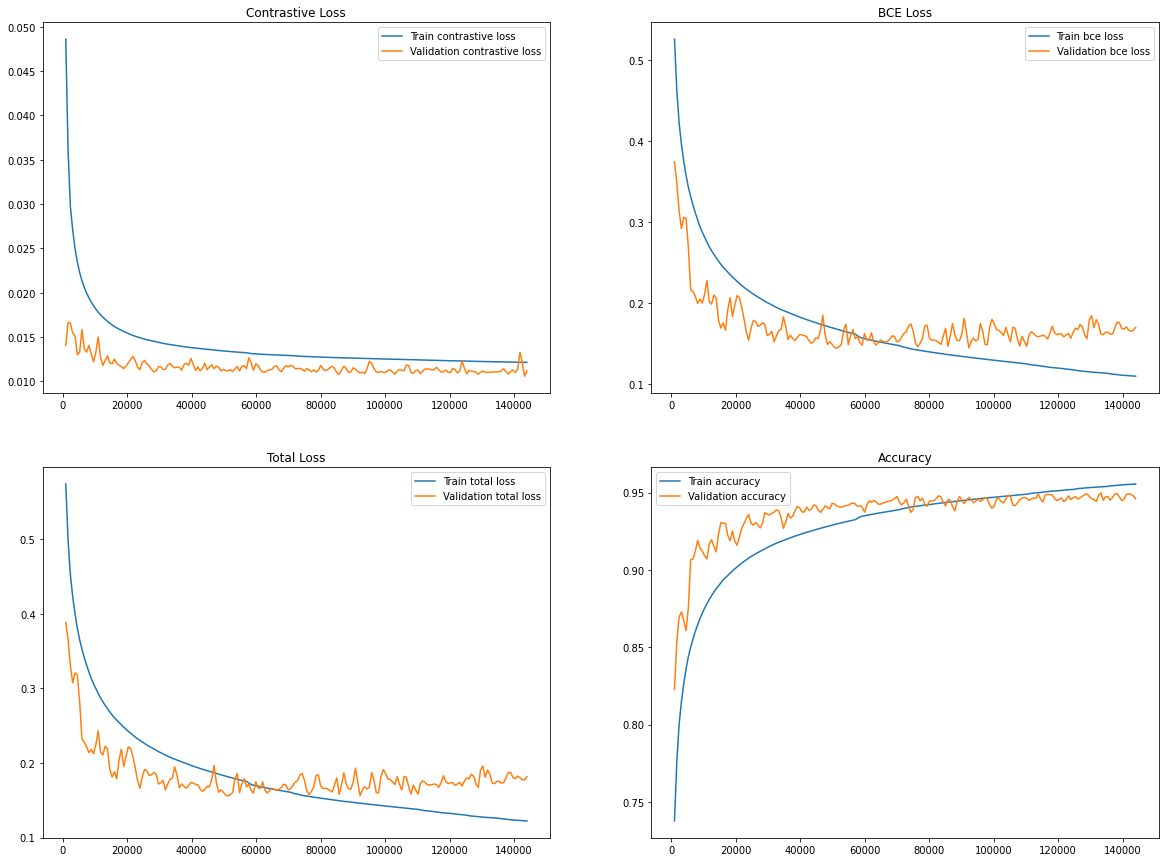

In [236]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import math

import os.path as osp
import csv
from typing import List

from torch import AnyType

def read_file(csv_file: str):
    """ 
    0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
    epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    epoch, Train loss, Train accuracy, Val loss,  Val accuracy,  Val real pre,  Val real rec,  Val real F1-Score,  Val fake pre,  Val fake rec,  Val fake F1-Score,  Val micro pre,  Val micro rec,  Val micro F1-Score, Val macro pre,  Val macro rec,  Val macro F1-Score
    Args:
        csv_file (str): path to file
    """
    global NUM_INFO
    global to_step
    result = [[] for _ in range(NUM_INFO)]
    # Read file
    file = open(csv_file)
    csvreader = csv.reader(file)
    # Get result:
    for idx, row in enumerate(csvreader):
        if idx == 0:
            continue
        if to_step is not None and idx > to_step:
            break
        for i in range(NUM_INFO):
            if i == 0:
                result[0].append(int(row[0]))
                continue
            result[i].append(float(row[i]))
    
    if 'test' in osp.basename(csv_file):
        phase = "Test"
    else:
        phase = "Validation"
        
    if 'epoch' in csv_file:
        iter_method = 'Epoch'
    else:
        iter_method = 'Step'
    
    results = []
    for i, r in enumerate(result):
        results.append(np.array(r, dtype=np.int32 if i == 0 else np.float32))
    return results, phase, iter_method

def number_of_step(csv_file: str):
    df = pd.read_csv(csv_file)
    return df.shape[0]

def plot_loss_and_accuracy(iter_loop: List[int], iter_method: str, values: List[List[float]], phase="Val", pairwise=False):
    """ values: [train_loss, train_acc, val_loss, val_acc]
    if pairwise: [train_contrastive_loss, train_bce_loss, train_total_loss, train_acc, val_contrastive, val_bce, val_total, val_accu]
    """
    global figsize_lossacc
    if pairwise:
        plt.figure(figsize=figsize_lossacc)
        plt.subplot(2, 2, 1)
        plt.plot(iter_loop, values[0], label="Train contrastive loss")
        plt.plot(iter_loop, values[4], label=phase + " contrastive loss")
        plt.legend()
        plt.title("Contrastive Loss")

        plt.subplot(2, 2, 2)
        plt.plot(iter_loop, values[1], label="Train bce loss")
        plt.plot(iter_loop, values[5], label=phase + " bce loss")
        plt.legend()
        plt.title("BCE Loss")
        # plt.xticks([i for i in range(1, len(epochs)+1)])
        # plt.yticks([0.1*i for i in range(1, 16)])
        
        plt.subplot(2, 2, 3)
        plt.plot(iter_loop, values[2], label="Train total loss")
        plt.plot(iter_loop, values[6], label=phase + " total loss")
        plt.legend()
        plt.title("Total Loss")

        plt.subplot(2, 2, 4)
        plt.plot(iter_loop, values[3], label="Train accuracy")
        plt.plot(iter_loop, values[7], label=phase + " accuracy")
        plt.legend()
        plt.title("Accuracy")

    else:
        plt.figure(figsize=figsize_lossacc)
        plt.subplot(1, 2, 1)
        plt.plot(iter_loop, values[0], label="Train total loss")
        plt.plot(iter_loop, values[2], label=phase + " total loss")
        plt.legend()
        plt.title("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(iter_loop, values[1], label="Train accuracy")
        plt.plot(iter_loop, values[3], label=phase + " accuracy")
        plt.legend()
        plt.title("Accuracy")
    plt.plot()
    # plt.savefig("result/Loss-Accuracy {} per {}.png".format(phase, iter_method))
    
def plot_metrics(iter_loop: List[int], iter_method: str, values: List[List[List[float]]], phase="Val"):
    """ values: [[pre, rec, f1] * [real, fake, micro, macro]]
    """
    plt.figure(figsize=(25, 10))
    assert len(values) == 4, "False parameter!"
    
    # i: 0 -> 3: real, fake, micro, macro
    title = ["Class real's metrics", "Class fake's metrics", "Micro average metrics", "Macro average metrics"]
    for i in range(0, 4):
        plt.subplot(2, 2, i+1)
        # j: 0 -> 2: precision, recall, f1-score
        plt.plot(iter_loop, values[i][0], label="Precision")
        plt.plot(iter_loop, values[i][1], label="Recall")
        plt.plot(iter_loop, values[i][2], label="F1-Score")
        plt.legend()
        plt.title(title[i])
    plt.plot()
    # plt.savefig("result/Metrics {} per {}.png".format(phase, iter_method))

def smooth_curve_with_pyplot(results: List[List[AnyType]], iter_method: str, phase='Val', pairwise=False):
    """results:
        0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
        epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    """
    from scipy.interpolate import make_interp_spline
    global NUM_INFO, INTERVAL, K_SPLINE_LOSS_ACC, K_SPLINE_METRIC
    
    iter_loop = results[0]
    iter_loop_new = np.linspace(iter_loop.min(), iter_loop.max(), INTERVAL)

    #define spline
    K = [-1] + [K_SPLINE_LOSS_ACC] * 8 + [K_SPLINE_METRIC] * 12
    spl = [make_interp_spline(iter_loop, results[i], k=K[i]) for i in range(1, NUM_INFO)]
    results_smooth = [-1] + [spl_item(iter_loop_new) for spl_item in spl]
    
    plot_loss_and_accuracy(iter_loop_new, iter_method, values=results_smooth[1:9], phase=phase, pairwise=pairwise)
    # plot_metrics(iter_loop_new, iter_method, values=[results_smooth[5: 8], results_smooth[8: 11], results_smooth[11: 14], results_smooth[14: 17]], phase=phase)

def plot_graph(csv_file: str):
    if csv_file == '':
        return
    results, phase, iter_method = read_file(csv_file)
    smooth_curve_with_pyplot(results, iter_method, phase, pairwise=True if 'pairwise' in csv_file else False)

def modify_csvfile(csvfile: str, phase: str):
    global num_sort
    df = pd.read_csv(csvfile)
    # COL:
    """
        step, Train loss, Train accuracy, Val loss, Val accuracy, Val real pre, Val real rec, Val real F1-Score, Val fake pre, Val fake rec, Val fake F1-Score, Val micro pre, Val micro rec, Val micro F1-Score, Val macro pre, Val macro rec, Val macro F1-Score
        0: step,                5: Val real pre     6: Val real rec     7: Val real F1
        1: Train loss           8: Val fake pre     9: Val fake rec     10:Val fake F1
        2: Train accuracy       11:Val micro pre    12:Val micro rec    13:Val micro F1
        3: Val loss             14:Val macro pre    15:Val macro rec    16:Val macro F1
        4: Val accuracy
    """
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 

    train_df = df[col[0:3]]
    val_df = df[col[3:]]
    sorted_part_val_df = val_df[:num_sort]
    none_sorted_part_val_df = val_df[num_sort:]
    sorted_part_val_df = sorted_part_val_df.sort_values([' {} loss'.format(phase)], ascending=False)
    sorted_val_df = sorted_part_val_df.append(none_sorted_part_val_df, sort=False, ignore_index=True)
    sorted_df = pd.concat([train_df, sorted_val_df], axis=1, ignore_index=False)
    sorted_df.to_csv(csvfile.replace('/result_', '/newres_'), index=False)
    return csvfile.replace('/result_', '/newres_')

def move_line_to_row(csv_file: str, phase: str, line: int, row: int):
    if line is None:
        return csv_file
    line, row = line - 2, row - 2
    df = pd.read_csv(csv_file)
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 
    train_df = df[col[:3]]
    val_df = df[col[3:]]

    idx_val_df = val_df.index.tolist()
    idx_val_df.pop(line)
    pos = row if line > row else row - 1
    new_idx = idx_val_df[:pos] + [line] + idx_val_df[pos:] 

    print(new_idx)
    val_df = val_df.reindex(new_idx)
    val_df.to_csv("tmp.csv", index=False)
    val_df = pd.read_csv("tmp.csv")

    swapped_df = pd.concat([train_df, val_df], axis=1, ignore_index=False)
    swapped_df.to_csv(csv_file, index=False)
    return csv_file

def move_line_to_row_pairwise(csv_file: str, phase: str, line: int, row: int):
    if line is None:
        return csv_file
    line, row = line - 2, row - 2
    df = pd.read_csv(csv_file)
    col = ['step', ' Train contrastive loss', ' Train bce loss', ' Train total loss', ' Train accuracy', ' {} contrastive loss'.format(phase), ' {} bce loss'.format(phase), ' {} total loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 
    train_df = df[col[:5]]
    val_df = df[col[5:]]

    idx_val_df = val_df.index.tolist()
    idx_val_df.pop(line)
    pos = row if line > row else row - 1
    new_idx = idx_val_df[:pos] + [line] + idx_val_df[pos:] 

    print(new_idx)
    val_df = val_df.reindex(new_idx)
    val_df.to_csv("tmp.csv", index=False)
    val_df = pd.read_csv("tmp.csv")

    swapped_df = pd.concat([train_df, val_df], axis=1, ignore_index=False)
    swapped_df.to_csv(csv_file, index=False)
    return csv_file

def reset_step(csv_file: str, phase: str, eval_per_iters: int):
    df = pd.read_csv(csv_file)
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 

    number_of_rows = len(df.index)
    for idx in range(1, number_of_rows+1):
        df.at[idx-1, 'step'] = eval_per_iters * idx
    df.to_csv(csv_file, index=False)

NUM_INFO = 17
INTERVAL = 200
K_SPLINE_LOSS_ACC = 2
K_SPLINE_METRIC = 2
num_sort = 20
to_step = None
figsize_lossacc = (20, 15)

if __name__ == '__main__':
    dict = {}
    methods = ['meso4', 'xception', 'dual_efficient', 'dual_attn_efficient', 'dual_efficient_vit']
    datasets = ['uadfv', 'ff_all', 'celeb_df', 'dfdc', 'df_in_the_wild']

    csv_file = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/test/dfdc/kfold_pairwise_dual_cnn_multivit/fold_2/result_val.csv"
    new_line=move_line_to_row_pairwise(csv_file=csv_file, phase='Val' if 'val' in csv_file else 'Test', line=71,row=30)
    print("Graph before modify")
    # plot_graph(new_line)
    # plot_graph(csv_file)

    # reset_step(csv_file=csv_file, phase='Val' if 'val' in csv_file else 'Test', eval_per_iters=1000)
    
    # print("Graph after modify")
    # newfile = modify_csvfile(csvfile=csv_file, phase='Val' if '/result_val' in csv_file else 'Test')
    plot_graph(csv_file)

In [37]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super().__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1][0] == 'f' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = None
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()
        print("freq combine: ", self.use_freq)

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class MultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8_0.4_0.2_0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(MultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('_')))
        self.gamma = []
        self.g0 = nn.Parameter(torch.ones(1))
        self.g1 = nn.Parameter(torch.ones(1))
        self.g2 = nn.Parameter(torch.ones(1))
        self.g3 = nn.Parameter(torch.ones(1))
        cnt = 0
        if residual:
            for g in self.gamma_reso:
                if g != 0:
                    self.gamma.append(g)
                else:
                    if cnt == 0:
                        self.gamma.append(self.g0)
                    if cnt == 1:
                        self.gamma.append(self.g1)
                    if cnt == 2:
                        self.gamma.append(self.g2)
                    if cnt == 3:
                        self.gamma.append(self.g3)
                    cnt += 1

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.patch_dim = [int(in_channels * (p ** 2)) for p in self.patch_size]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
        else:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        for i in range(len(self.patch_size)):
            # Flatten to vectors:
            rgb_vectors = self.flatten_to_vectors(feature=rgb_features, p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freq_features, p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreq_features, p_size=self.patch_size[i])  # B, num_patch, patch_dim
            # print("patchsize: ", self.patch_size[i])
            # print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            # print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            # print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        # print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
    
class DualCNNMultiViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8_0.4_0.2_0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10', use_dab='1-3-6-9', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True):  

        super(DualCNNMultiViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.use_dab = use_dab
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])

        self.multi_transformer = MultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
                freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            else:
                rgb_features = self.rgb_extractor.extract_features_at_block(rgb_imgs, int(self.features_at_block))
                freq_features = self.freq_extractor.extract_features_at_block(freq_imgs, int(self.features_at_block))
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        x = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(x)         # B, number_of_patch * D
        x = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(x)
        x = self.mlp_dropout(x)
        x = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualCNNMultiViT(image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2', gammaagg_reso='0.8_0.4',\
                fusca_version='ca-ifcat-0.5',\
                features_at_block='10',\
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True)

    out = model_(x, y)
    print(out.shape)


Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
freq combine:  False
freq combine:  False
torch.Size([32, 1])


In [52]:
import pandas as pd

def modify_csvfile(csvfile: str, phase: str):
    global num_sort
    print(num_sort)
    df = pd.read_csv(csvfile)
    # COL:
    """
        step, Train loss, Train accuracy, Val loss, Val accuracy, Val real pre, Val real rec, Val real F1-Score, Val fake pre, Val fake rec, Val fake F1-Score, Val micro pre, Val micro rec, Val micro F1-Score, Val macro pre, Val macro rec, Val macro F1-Score
        0: step,                5: Val real pre     6: Val real rec     7: Val real F1
        1: Train loss           8: Val fake pre     9: Val fake rec     10:Val fake F1
        2: Train accuracy       11:Val micro pre    12:Val micro rec    13:Val micro F1
        3: Val loss             14:Val macro pre    15:Val macro rec    16:Val macro F1
        4: Val accuracy
    """
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 

    train_df = df[col[0:3]]
    val_df = df[col[3:]]
    sorted_part_val_df = val_df[:num_sort]
    none_sorted_part_val_df = val_df[num_sort:]
    sorted_part_val_df = sorted_part_val_df.sort_values([' {} loss'.format(phase)], ascending=False)
    sorted_val_df = sorted_part_val_df.append(none_sorted_part_val_df, sort=False, ignore_index=True)
    sorted_df = pd.concat([train_df, sorted_val_df], axis=1, ignore_index=False)
    sorted_df.to_csv(csvfile.replace('/result_', '/newres_'), index=False)
    return csvfile.replace('/result_', '/newres_')

csvfile = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/test/df_in_the_wild/dual_efficient_vit/result_test.csv"
df_1 = pd.read_csv(csvfile)
df_1.info()
new_file = modify_csvfile(csvfile, 'Test')
df_2 = pd.read_csv(new_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  87 non-null     int64  
 1    Train loss           87 non-null     float64
 2    Train accuracy       87 non-null     float64
 3    Test loss            87 non-null     float64
 4    Test accuracy        87 non-null     float64
 5    Test real pre        87 non-null     float64
 6    Test real rec        87 non-null     float64
 7    Test real F1-Score   87 non-null     float64
 8    Test fake pre        87 non-null     float64
 9    Test fake rec        87 non-null     float64
 10   Test fake F1-Score   87 non-null     float64
 11   Test micro pre       87 non-null     float64
 12   Test micro rec       87 non-null     float64
 13   Val micro F1-Score   87 non-null     float64
 14   Test macro pre       87 non-null     float64
 15   Test macro rec       87 

/tmp/ipykernel_44582/3962535049.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sorted_val_df = sorted_part_val_df.append(none_sorted_part_val_df, sort=False, ignore_index=True)


In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer, FeedForward, PreNorm
# from model.vision_transformer.vit.kvit import kNNTransformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super().__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1][0] == 'f' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = None
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()
        print("freq combine: ", self.use_freq)

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class MultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8_0.4_0.2_0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                useKNN=0, depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(MultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('_')))
        self.gamma = []
        self.g0 = nn.Parameter(torch.ones(1))
        self.g1 = nn.Parameter(torch.ones(1))
        self.g2 = nn.Parameter(torch.ones(1))
        self.g3 = nn.Parameter(torch.ones(1))
        cnt = 0
        if residual:
            for g in self.gamma_reso:
                if g != 0:
                    self.gamma.append(g)
                else:
                    if cnt == 0:
                        self.gamma.append(self.g0)
                    if cnt == 1:
                        self.gamma.append(self.g1)
                    if cnt == 2:
                        self.gamma.append(self.g2)
                    if cnt == 3:
                        self.gamma.append(self.g3)
                    cnt += 1

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.patch_dim = [int(in_channels * (p ** 2)) for p in self.patch_size]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                if useKNN == 0:
                    print("use vanilla attention")
                    self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
                elif useKNN > 0:
                    print("use KNN attention: topK ratio: ", useKNN)
                    self.transformers.append(kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN))
                else:
                    print("error when use attention...")
        else:
            if useKNN == 0:
                print("use vanilla attention")
                self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            elif useKNN > 0:
                print("use KNN attention: topK ratio: ", useKNN)
                self.transformer = kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN)
            else:
                print("error when use attention...")
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        for i in range(len(self.patch_size)):
            # Flatten to vectors:
            rgb_vectors = self.flatten_to_vectors(feature=rgb_features, p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freq_features, p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreq_features, p_size=self.patch_size[i])  # B, num_patch, patch_dim
            # print("patchsize: ", self.patch_size[i])
            # print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            # print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            # print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
class kNNAttention(nn.Module):
    def __init__(self,dim,num_heads=8,qkv_bias=False,qk_scale=None,attn_drop=0.,proj_drop=0.,topk_ratio=100):
        super().__init__()
        self.num_heads=num_heads
        head_dim = dim//num_heads
        self.scale=qk_scale or head_dim**-0.5
        self.topk_ratio = topk_ratio

        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop=nn.Dropout(attn_drop)
        self.proj=nn.Linear(dim,dim)
        self.proj_drop=nn.Dropout(proj_drop)

    def forward(self,x):
        B, N, C =x.shape
        print("x.shape: ", x.shape)
        topk = int(self.topk_ratio * N) if N != 1 else 1
        # print("topk: ", topk)
        # print("C: ", C)
        qkv=self.qkv(x).reshape(B,N,3,self.num_heads, C//self.num_heads).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2] #B,H,N,C
        attn=(q@k.transpose(-2,-1))*self.scale #B,H,N,N
        print("attn before core code: ", attn)

        # the core code block
        mask=torch.zeros(B,self.num_heads,N,N,device=x.device,requires_grad=False)
        index=torch.topk(attn,k=topk,dim=-1,largest=True)[1]
        mask.scatter_(-1,index,1.)
        attn=torch.where(mask>0,attn,torch.full_like(attn,float('-inf')))

        print("attn after core code: ", attn)

        # end of the core code block
        attn=torch.softmax(attn,dim=-1)
        attn=self.attn_drop(attn)
        x=(attn@v).transpose(1,2).reshape(B,N,C)
        x=self.proj(x)
        x=self.proj_drop(x)
        return x

class kNNTransformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout = 0.0, topk_ratio=0.5):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, kNNAttention(dim, num_heads=heads, proj_drop=dropout, topk_ratio=topk_ratio)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class PairwiseDualCNNMultiViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8_0.4_0.2_0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10', use_dab='1-3-6-9', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, embedding_return="mlp_hidden", useKNN=0):  

        super(PairwiseDualCNNMultiViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.use_dab = use_dab
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])

        self.multi_transformer = MultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          useKNN=useKNN, depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        #
        self.embedding_return = embedding_return

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
                freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            else:
                rgb_features = self.rgb_extractor.extract_features_at_block(rgb_imgs, int(self.features_at_block))
                freq_features = self.freq_extractor.extract_features_at_block(freq_imgs, int(self.features_at_block))
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        e1 = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(e1)         # B, number_of_patch * D
        print('x = ', x)
        print('e1 = ', e1)
        e2 = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(e2)
        x = self.mlp_dropout(x)
        e3 = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        print('e3: ', e3)
        x = self.sigmoid(e3)
        e = None
        if self.embedding_return=='mlp_before':
            e = e1
        if self.embedding_return=='mlp_hidden':
            e = e2
        if self.embedding_return=='mlp_out':
            e = e3
        return e, x

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        # print("embed: ", embedding_0.shape, "   out: ", out_0.shape)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualCNNMultiViT(image_size=128, num_classes=1, \
                dim=1024, depth=1, heads=4, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='4', gammaagg_reso='0',\
                fusca_version='ca-ifadd-0.8',\
                features_at_block='11',\
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=False, \
                embedding_return="mlp_before", useKNN=0.5)

    embed, out, _, _ = model_(x, y, x, y)
    print(embed)
    print(out)


In [48]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.vit.kvit import kNNTransformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class DAB(nn.Module):
    def __init__(self, n_feat: int, reduction: int, topk_rate=0.5, act_dab=None, dab_modules='sa-ca'):
        super(DAB, self).__init__()
        self.use_sa = True if 'sa' in dab_modules else False
        self.use_ca = True if 'ca' in dab_modules else False
        self.dab_modules = dab_modules
        self.SA = spatial_attn_layer() if self.use_sa else None             ## Spatial Attention
        self.CA = CALayer(n_feat, reduction)  if self.use_ca else None      ## Channel Attention
        self.conv1x1_1 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        # self.conv1x1_2 = nn.Conv2d(n_feat, n_feat, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(int(n_feat * (1 + topk_rate)), n_feat, kernel_size=1)
        self.act = act_dab
        self.topk_rate = topk_rate

    def forward(self, ifreq, rgb):
        if self.use_sa:
            sa_branch = self.SA(ifreq)
        if self.use_ca:
            ca_branch = self.CA(ifreq)

        if self.use_sa and self.use_ca:
            attn = torch.cat([sa_branch, ca_branch], dim=1)
        if self.use_sa and not self.use_ca:
            attn = sa_branch
        if not self.use_sa and self.use_ca:
            attn = ca_branch

        topk = int(self.topk_rate * ifreq.shape[1])
        attn = torch.topk(input=attn,k=topk,dim=1,largest=True,sorted=False).values

        if '-' in self.dab_modules:
            attn = self.conv1x1_1(attn)

        # print("        attn shape: ", rgb.shape, attn.shape)
        res = torch.cat([rgb, attn], dim=1)
        res = self.conv1x1_3(res)
        if self.act:
            res = self.act(res)
        return res

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super().__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1][0] == 'f' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = activation
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()
        print("freq combine: ", self.use_freq)

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class MultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8_0.4_0.2_0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                useKNN=0, depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(MultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('_')))
        self.gamma = []
        self.g0 = nn.Parameter(torch.ones(1))
        self.g1 = nn.Parameter(torch.ones(1))
        self.g2 = nn.Parameter(torch.ones(1))
        self.g3 = nn.Parameter(torch.ones(1))
        cnt = 0
        if residual:
            for g in self.gamma_reso:
                if g != 0:
                    self.gamma.append(g)
                else:
                    if cnt == 0:
                        self.gamma.append(self.g0)
                    if cnt == 1:
                        self.gamma.append(self.g1)
                    if cnt == 2:
                        self.gamma.append(self.g2)
                    if cnt == 3:
                        self.gamma.append(self.g3)
                    cnt += 1

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.patch_dim = [int(in_channels * (p ** 2)) for p in self.patch_size]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                if useKNN == 0:
                    print("use vanilla attention")
                    self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
                elif useKNN > 0:
                    print("use KNN attention: topK ratio: ", useKNN)
                    self.transformers.append(kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN))
                else:
                    print("error when use attention...")
        else:
            if useKNN == 0:
                print("use vanilla attention")
                self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            elif useKNN > 0:
                print("use KNN attention: topK ratio: ", useKNN)
                self.transformer = kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN)
            else:
                print("error when use attention...")
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        for i in range(len(self.patch_size)):
            # Flatten to vectors:
            rgb_vectors = self.flatten_to_vectors(feature=rgb_features, p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freq_features, p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreq_features, p_size=self.patch_size[i])  # B, num_patch, patch_dim
            # print("patchsize: ", self.patch_size[i])
            # print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            # print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            # print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        # print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
class PairwiseDualDabCNNMultiViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8_0.4_0.2_0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, \
                act_dab='none', topk_channels=0.5, dab_modules='sa-ca', dabifft_normalize='none', dab_blocks='1_3_6_9', \
                embedding_return='mlp_hidden', useKNN=0):  

        super(PairwiseDualDabCNNMultiViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone
        if 'efficient_net' in backbone:
            dab_blocks = '-1_' + dab_blocks
        self.dab_blocks = sorted(list(map(int, dab_blocks.split('_'))))
        print("dab blocks: ", self.dab_blocks)
        self.dabifft_normalize = dabifft_normalize
        self.last_block = int(features_at_block) if features_at_block != 'final' else 15

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)
        self.dab_activation = self.get_activation(act_dab)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])
        
        # DAB Block:
        num_dab = len(self.dab_blocks) - 1
        self.dab = nn.ModuleList([])
        for i in range(num_dab):
            at_block = self.dab_blocks[i+1]
            in_features = self.features_size[backbone][str(at_block)][0]
            self.dab.append(DAB(n_feat=in_features, reduction=1, topk_rate=topk_channels, act_dab=self.dab_activation, dab_modules=dab_modules))

        # Multi ViT:
        self.multi_transformer = MultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          useKNN=useKNN, depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        #
        self.embedding_return = embedding_return

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            # Conv stem:
            rgb_features = self.rgb_extractor.extract_features_convstem(rgb_imgs)                 
            freq_features = self.freq_extractor.extract_features_convstem(freq_imgs)
            # print("Features shape: ", rgb_features.shape)
            # DAB Block:
            for i in range(len(self.dab_blocks) - 1):   # -1_1_3_6_9
                                                        #  0 1 2 3 4
                # print("dab_blocks: ", self.dab_blocks[i]+1, ' -> ', self.dab_blocks[i+1])
                rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                # Attention, concat and reduce channels:
                ifreq_features = self.ifft(freq_features, norm_type=self.dabifft_normalize)
                # print(" Shape: ", rgb_features.shape, ifreq_features.shape)
                rgb_features = self.dab[i](ifreq_features, rgb_features)

            # Last block:
            rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            
            # Convhead:
            # print("After last block Features shape: ", rgb_features.shape, freq_features.shape)
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features_convhead(rgb_features)
                freq_features = self.freq_extractor.extract_features_convhead(freq_features)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        e1 = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(e1)         # B, number_of_patch * D
        e2 = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(e2)
        x = self.mlp_dropout(x)
        e3 = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(e3)
        e = None
        if self.embedding_return=='mlp_before':
            e = e1
        if self.embedding_return=='mlp_hidden':
            e = e2
        if self.embedding_return=='mlp_out':
            e = e3
        return e, x

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        # print("embed: ", embedding_0.shape, "   out: ", out_0.shape)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(2, 3, 128, 128)
    y = torch.ones(2, 1, 128, 128)
    model_ = PairwiseDualDabCNNMultiViT(image_size=128, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='selu',\
                patch_reso='1-2-4', gammaagg_reso='0.8_0.4_0.2',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='11', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, \
                act_dab='selu', topk_channels=0.5, dab_modules='ca', dabifft_normalize='normal', dab_blocks='0_3_5_6_10', \
                embedding_return="mlp_out")
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
    x, y = x.to(device), y.to(device)
    model_ = model_.to(device)

    embed, out, _, _ = model_(x, y, x, y)
    print(embed.shape)
    print(out.shape)

dab blocks:  [-1, 0, 3, 5, 6, 10]
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
freq combine:  True
freq combine:  True
freq combine:  True
use vanilla attention
torch.Size([2, 1])
torch.Size([2, 1])


img:  (323, 222)
[[9.73384248+0.00000000e+00j 0.50158104-4.33837150e-17j
  0.24798811-4.88223076e-17j ... 0.16318971-3.74345075e-17j
  0.24798811+4.59093609e-17j 0.50158104+4.02739720e-17j]
 [8.66673518+0.00000000e+00j 0.5844471 -1.99236571e-02j
  0.34180389-1.73130700e-02j ... 0.2416508 -2.82836112e-03j
  0.34180389+1.73130700e-02j 0.5844471 +1.99236571e-02j]
 [8.72487226+0.00000000e+00j 0.57177648-2.29391307e-02j
  0.32530928-1.99808648e-02j ... 0.21660477+6.39945949e-03j
  0.32530928+1.99808648e-02j 0.57177648+2.29391307e-02j]
 ...
 [8.09016359+0.00000000e+00j 0.68987642-2.84089017e-02j
  0.38277591-3.78410160e-02j ... 0.26477868+2.26127862e-02j
  0.38277591+3.78410160e-02j 0.68987642+2.84089017e-02j]
 [8.72487226+0.00000000e+00j 0.57177648+2.29391307e-02j
  0.32530928+1.99808648e-02j ... 0.21660477-6.39945949e-03j
  0.32530928-1.99808648e-02j 0.57177648-2.29391307e-02j]
 [8.66673518+0.00000000e+00j 0.5844471 +1.99236571e-02j
  0.34180389+1.73130700e-02j ... 0.2416508 +2.82836112e-0

TypeError: Image data of dtype complex128 cannot be converted to float

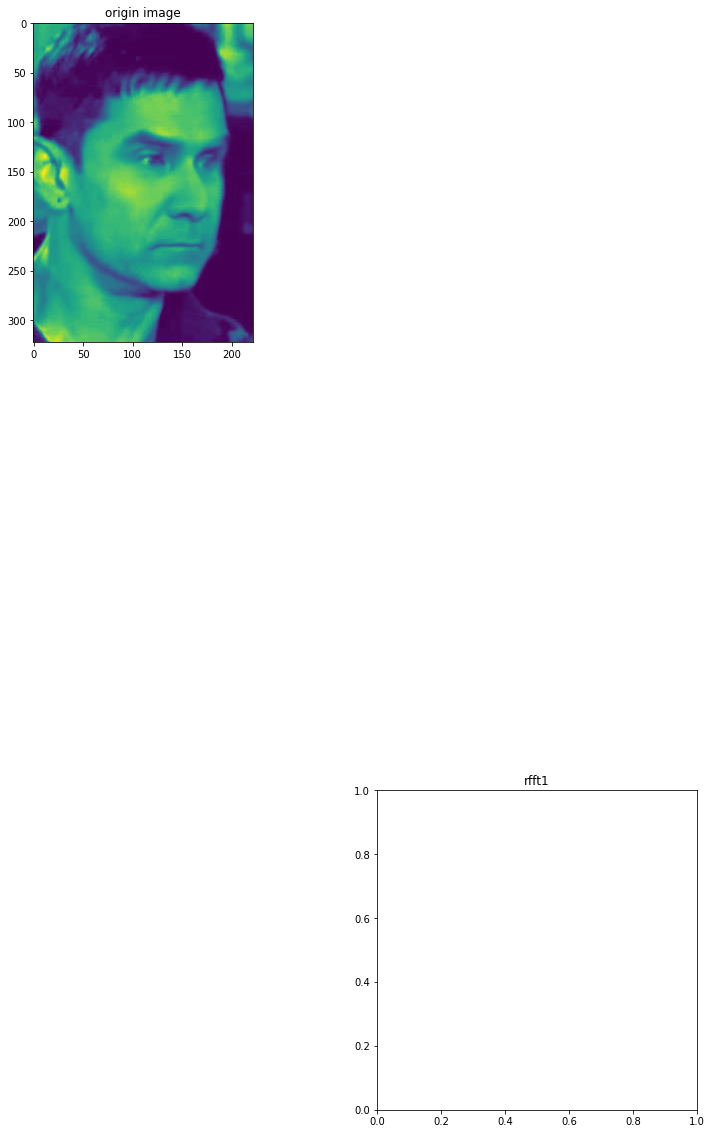

In [3]:
import torch
import cv2
from PIL import Image
import numpy as np

img = cv2.imread("/mnt/disk1/doan/phucnp/Dataset/Celeb-DFv6/image/test/1_df/id0_id6_0007_30.jpg")
img = cv2.cvtColor(img, code=cv2.COLOR_BGR2GRAY)
print("img: ", img.shape)

fft = np.fft.fft2(img)

rfft1 = np.fft.rfft(img)
abs_rfft1 = np.abs(rfft1)

rfft2 = np.fft.rfft2(img)


fft_shift = np.fft.fftshift(fft)

mag = np.log(np.abs(fft_shift))

import matplotlib.pyplot as plt

ifftshift_mag = np.fft.ifftshift(mag)
ifft_mag = np.fft.ifft(ifftshift_mag)
print(ifft_mag)

plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.title("origin image")
plt.imshow(img)


plt.subplot(3, 3, 8)
plt.title("rfft1")
plt.imshow(rfft1)

plt.subplot(3, 3, 9)
plt.title("rfft2")
plt.imshow(rfft2)

plt.subplot(3, 3, 2)
plt.title("magnitude")
plt.imshow(mag)

plt.subplot(3, 3, 3)
plt.title("iftshift of mag")
plt.imshow(ifftshift_mag)



plt.show()



In [5]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.vit.kvit import kNNTransformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
import torch.nn.functional as F
from pytorchcv.model_provider import get_model

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, topk_rate=0.5):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.channel = channel
        self.topk_rate = topk_rate
        self.topk = int(channel * topk_rate)

    def forward(self, x):

        # x: B, C, W, H
        # y: B, C, 1, 1
        y = self.avg_pool(x)
        attn_weight = self.conv_du(y)   # B, C, 1, 1
        attn = attn_weight * x
        attnw_idx = torch.topk(input=attn_weight,k=self.topk,dim=1,largest=True, sorted=False).indices  # B, k, 1, 1
        attnw_idx = torch.sort(attnw_idx, dim=1).values
        attnw_idx = attnw_idx.expand(-1, -1, x.shape[2], x.shape[3])     
        attn = torch.gather(attn, dim=1, index=attnw_idx)
        return attn


class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class DAB(nn.Module):
    def __init__(self, n_feat: int, reduction: int, topk_rate=0.5, act_dab=None, dab_modules='sa-ca'):
        super(DAB, self).__init__()
        self.use_sa = True if 'sa' in dab_modules else False
        self.use_ca = True if 'ca' in dab_modules else False
        self.dab_modules = dab_modules
        self.SA = spatial_attn_layer() if self.use_sa else None             ## Spatial Attention
        self.CA = CALayer(n_feat, reduction, topk_rate)  if self.use_ca else None      ## Channel Attention
        self.conv1x1_1 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        # self.conv1x1_2 = nn.Conv2d(n_feat, n_feat, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(int(n_feat * (1 + topk_rate)), n_feat, kernel_size=1)
        self.act = act_dab
        self.topk_rate = topk_rate

    def forward(self, ifreq, rgb):
        if self.use_sa:
            sa_branch = self.SA(ifreq)
        if self.use_ca:
            ca_branch = self.CA(ifreq)

        if self.use_sa and self.use_ca:
            attn = torch.cat([sa_branch, ca_branch], dim=1)
        if self.use_sa and not self.use_ca:
            attn = sa_branch
        if not self.use_sa and self.use_ca:
            attn = ca_branch

        # print(attn.shape)
        if '-' in self.dab_modules:
            attn = self.conv1x1_1(attn)

        # print("        attn shape: ", rgb.shape, attn.shape)
        res = torch.cat([rgb, attn], dim=1)
        res = self.conv1x1_3(res)
        if self.act:
            res = self.act(res)
        return res
    
class DualDabCNN(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                mlp_dim=2048,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                features_at_block='10', \
                dropout_in_mlp=0.0,
                act_dab='none', topk_channels=0.5, dab_modules='sa-ca', dabifft_normalize='none', dab_blocks='1_3_6_9'):  

        super(DualDabCNN, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone
        if 'efficient_net' in backbone:
            dab_blocks = '-1_' + dab_blocks
        self.dab_blocks = sorted(list(map(int, dab_blocks.split('_'))))
        print("dab blocks: ", self.dab_blocks)
        self.dabifft_normalize = dabifft_normalize
        self.last_block = int(features_at_block) if features_at_block != 'final' else 15

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.dab_activation = self.get_activation(act_dab)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])
        
        # DAB Block:
        num_dab = len(self.dab_blocks) - 1
        self.dab = nn.ModuleList([])
        for i in range(num_dab):
            at_block = self.dab_blocks[i+1]
            in_features = self.features_size[backbone][str(at_block)][0]
            self.dab.append(DAB(n_feat=in_features, reduction=1, topk_rate=topk_channels, act_dab=self.dab_activation, dab_modules=dab_modules))

        # Multi ViT:
        # print(type(useKNN))
        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_hidden = nn.Linear(2 * self.out_ext_channels, mlp_dim)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            # Conv stem:
            rgb_features = self.rgb_extractor.extract_features_convstem(rgb_imgs)                 
            freq_features = self.freq_extractor.extract_features_convstem(freq_imgs)
            # print("Features shape: ", rgb_features.shape)
            # DAB Block:
            for i in range(len(self.dab_blocks) - 1):   # -1_1_3_6_9
                                                        #  0 1 2 3 4
                # print("dab_blocks: ", self.dab_blocks[i]+1, ' -> ', self.dab_blocks[i+1])
                rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                # Attention, concat and reduce channels:
                ifreq_features = self.ifft(freq_features, norm_type=self.dabifft_normalize)
                # print(" Shape: ", rgb_features.shape, ifreq_features.shape)
                rgb_features = self.dab[i](ifreq_features, rgb_features)

            # Last block:
            rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            
            # Convhead:
            # print("After last block Features shape: ", rgb_features.shape, freq_features.shape)
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features_convhead(rgb_features)
                freq_features = self.freq_extractor.extract_features_convhead(freq_features)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        print("Features shape: ", rgb_features.shape, freq_features.shape)

        ##### Forward to ViT
        # x = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D
        x = torch.cat([rgb_features, freq_features], dim=1)
        x = F.adaptive_avg_pool2d(x, output_size=(1, 1)).squeeze(dim=-1).squeeze(dim=-1)

        x = self.mlp_dropout(x)         # B, number_of_patch * D
        x = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(x)
        x = self.mlp_dropout(x)
        x = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(2, 3, 128, 128)
    y = torch.ones(2, 1, 128, 128)
    model_ = DualDabCNN(image_size=128, num_classes=1, \
                mlp_dim=2048,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                features_at_block='11', \
                act_dab='none', topk_channels=0.5, dab_modules='ca', dabifft_normalize='normal', dab_blocks='0_3_5_6_10')
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
    x, y = x.to(device), y.to(device)
    model_ = model_.to(device)

    out = model_(x, y)
    print(out.shape)

dab blocks:  [-1, 0, 3, 5, 6, 10]
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Features shape:  torch.Size([2, 192, 4, 4]) torch.Size([2, 192, 4, 4])
torch.Size([2, 1])


In [66]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.vit.kvit import kNNTransformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, version='ca-fcat-0.5', in_dim=1024, activation=None, inner_dim=0, prj_out=False, qkv_embed=True):
        super().__init__()
        self.version = version
        self.use_freq = True if self.version.split('-')[1][0] == 'f' else False
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.to_out = nn.Identity()
        self.activation = activation
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()
        print("freq combine: ", self.use_freq)

    def forward(self, rgb, freq, ifreq):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(rgb)
            k = self.to_k(freq)
            v = self.to_v(ifreq)
        else:
            q, k, v = rgb, freq, ifreq
        attn_rgb_to_ifreq, attnweight_rgb_to_ifreq = self.scale_dot(q, k, v, dropout_p=0.00)
        if self.use_freq:
            attn_rgb_to_freq = torch.bmm(attnweight_rgb_to_ifreq, freq)
            attn_out = self.to_out(attn_rgb_to_freq)
        else:
            attn_out = self.to_out(attn_rgb_to_ifreq)
            
        fusion_out = self.fusion(rgb, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        return fusion_out

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

class CMultiscaleViT(nn.Module):
    def __init__(self, in_channels=112, in_size=8, patch_reso='1-2-4-8', gamma_reso='0.8_0.4_0.2_0.1', residual=True,\
                qkv_embed=True, prj_out=True, activation=None, fusca_version='ca-fcat-0.5', \
                useKNN=True, depth=6, heads=8, dim=1024, mlp_dim=2048, dim_head=64, dropout=0.15, share_weight=True):
        super(CMultiscaleViT, self).__init__()
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout_value = dropout

        self.fusca_version = fusca_version
        self.residual = residual
        self.patch_reso = patch_reso
        self.gamma_reso = gamma_reso

        self.patch_size = list(map(int, patch_reso.split('-')))
        self.gamma_reso = list(map(float, gamma_reso.split('_')))
        self.gamma = []
        self.g0 = nn.Parameter(torch.ones(1))
        self.g1 = nn.Parameter(torch.ones(1))
        self.g2 = nn.Parameter(torch.ones(1))
        self.g3 = nn.Parameter(torch.ones(1))
        cnt = 0
        if residual:
            for g in self.gamma_reso:
                if g != 0:
                    self.gamma.append(g)
                else:
                    if cnt == 0:
                        self.gamma.append(self.g0)
                    if cnt == 1:
                        self.gamma.append(self.g1)
                    if cnt == 2:
                        self.gamma.append(self.g2)
                    if cnt == 3:
                        self.gamma.append(self.g3)
                    cnt += 1

        self.num_patches = [int((in_size // p)** 2) for p in self.patch_size]
        self.n_chunks = len(self.patch_size)
        with torch.no_grad():
            test_inp = torch.ones(4, in_channels, in_size, in_size)
            test_chunks = torch.chunk(test_inp, chunks=self.n_chunks, dim=1)
            self.chunk_channels = [chunk.shape[1] for chunk in test_chunks]
        self.patch_dim = [int(self.chunk_channels[i] * (self.patch_size[i] ** 2)) for i in range(self.n_chunks)]

        ############################# CROSS ATTENTION #############################
        self.cross_attention = nn.ModuleList([])
        for p_dim in self.patch_dim:
            self.cross_attention.append(CrossAttention(version=fusca_version, in_dim=p_dim, activation=activation, inner_dim=0, prj_out=prj_out, qkv_embed=qkv_embed))

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.embedding = nn.ModuleList([])
        for p_dim in self.patch_dim:
            if 'cat' in self.fusca_version:
                self.embedding.append(nn.Linear(2 * p_dim, self.dim))
            else:
                self.embedding.append(nn.Linear(p_dim, self.dim))
        # transformer:
        self.share_weight = share_weight
        if not share_weight:
            self.transformers = nn.ModuleList([])
            for _ in range(len(self.patch_size)):
                if useKNN == 0:
                    print("use vanilla attention")
                    self.transformers.append(Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value))
                elif useKNN > 0:
                    print("use KNN attention: topK ratio: ", useKNN)
                    self.transformers.append(kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN))
                else:
                    print("error when use attention...")
        else:
            if useKNN == 0:
                print("use vanilla attention")
                self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            elif useKNN > 0:
                print("use KNN attention: topK ratio: ", useKNN)
                self.transformer = kNNTransformer(self.dim, self.depth, self.heads, self.mlp_dim, self.dropout_value, useKNN)
            else:
                print("error when use attention...")
        
    def forward(self, rgb_features, freq_features, ifreq_features):
        outputs = []
        rgbs = torch.chunk(rgb_features, self.n_chunks, dim=1)
        freqs = torch.chunk(freq_features, self.n_chunks, dim=1)
        ifreqs = torch.chunk(ifreq_features, self.n_chunks, dim=1)

        for i in range(self.n_chunks):
            # Flatten to vectors:
            # print("shape: ", rgbs[i].shape, " ", freqs[i].shape, " ", ifreqs[i].shape)
            rgb_vectors = self.flatten_to_vectors(feature=rgbs[i], p_size=self.patch_size[i])      # B, num_patch, patch_dim
            freq_vectors = self.flatten_to_vectors(feature=freqs[i], p_size=self.patch_size[i])    # B, num_patch, patch_dim
            ifreq_vectors = self.flatten_to_vectors(feature=ifreqs[i], p_size=self.patch_size[i])  # B, num_patch, patch_dim
            # print("patchsize: ", self.patch_size[i])
            # print("     Vectors shape: ", rgb_vectors.shape, freq_vectors.shape, ifreq_vectors.shape)

            # Cross attention:
            attn_out = self.cross_attention[i](rgb_vectors, freq_vectors, ifreq_vectors)    # B, num_patch, patch_dim/2*patch_dim
            # print("     attn out shape: ", attn_out.shape)

            # ViT:
            embed = self.embedding[i](attn_out)                # B, num_patch, dim
            if not self.share_weight:       
                output = self.transformers[i](embed)                # B, num_patch, dim
            else:
                output = self.transformer(embed)
            if self.residual:
                output = embed + self.gamma[i] * output        # B, num_patch, dim
            # print("     output shape: ", output.shape)
            output = output.mean(dim = 1).squeeze(dim=1)          # B, 1, dim
            outputs.append(output)
        
        out = torch.cat(outputs, dim=1)
        # print("multi shape: ", out.shape)
        return out

    def flatten_to_vectors(self, feature=None, p_size=1):
        return rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p_size, p2=p_size)

    
    
class PairwiseDualCNNCMultiViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2-4-8', gammaagg_reso='0.8_0.4_0.2_0.1',\
                fusca_version='ca-fcat-0.5',\
                features_at_block='10', use_dab='1-3-6-9', \
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, embedding_return="mlp_hidden", useKNN=0):  

        super(PairwiseDualCNNCMultiViT, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.fusca_version = fusca_version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.use_dab = use_dab
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[backbone][features_at_block])

        self.multi_transformer = CMultiscaleViT(in_channels=self.out_ext_channels, in_size=self.out_ext_size, patch_reso=patch_reso, gamma_reso=gammaagg_reso,\
                                          qkv_embed=qkv_embed, prj_out=prj_out, activation=self.activation, fusca_version=fusca_version,\
                                          useKNN=useKNN, depth=depth, heads=heads, dim=dim, mlp_dim=mlp_dim, dim_head=dim_head, dropout=dropout, residual=residual, share_weight=transformer_shareweight)

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(len(patch_reso.split('-')) * dim, mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        #
        self.embedding_return = embedding_return

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
                freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            else:
                rgb_features = self.rgb_extractor.extract_features_at_block(rgb_imgs, int(self.features_at_block))
                freq_features = self.freq_extractor.extract_features_at_block(freq_imgs, int(self.features_at_block))
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        ##### Forward to ViT
        e1 = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D

        x = self.mlp_dropout(e1)         # B, number_of_patch * D
        e2 = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(e2)
        x = self.mlp_dropout(x)
        e3 = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(e3)
        e = None
        if self.embedding_return=='mlp_before':
            e = e1
        if self.embedding_return=='mlp_hidden':
            e = e2
        if self.embedding_return=='mlp_out':
            e = e3
        return e, x

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        # print("embed: ", embedding_0.shape, "   out: ", out_0.shape)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = PairwiseDualCNNCMultiViT(image_size=224, num_classes=1, \
                dim=1024, depth=6, heads=8, mlp_dim=2048, dim_head=64, dropout=0.15,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                normalize_ifft='batchnorm',\
                qkv_embed=True, prj_out=False, act='none',\
                patch_reso='1-2', gammaagg_reso='0.8_0.4',\
                fusca_version='ca-ifcat-0.5',\
                features_at_block='11',\
                dropout_in_mlp=0.0, residual=True, transformer_shareweight=True, \
                embedding_return="mlp_before", useKNN=0)

    embed, out, _, _ = model_(x, y, x, y)
    print(embed.shape)
    print(out.shape)


Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
freq combine:  False
freq combine:  False
use vanilla attention
torch.Size([32, 2048])
torch.Size([32, 1])


In [3]:
from glob import glob
a = [1]
b = glob('/mnt/disk1/doan/phucnp/Dataset/df_in_the_wildv6/image/val/0_real/*') 
a.extend(b)
b

[]

In [80]:
import torch
torch.manual_seed(0)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, topk_rate=0.5):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.channel = channel
        self.topk_rate = topk_rate
        self.topk = int(channel * topk_rate)


    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        print("weight: ", y.shape, "\n", y)
        attn = x * y
        print("attn: \n", attn)
        ################ TOP K:
        attnw_idx = torch.topk(input=y, k=self.topk,dim=1,largest=True, sorted=False).indices  # B, k, 1, 1
        # print("indices: \n", attnw_idx)
        attnw_idx = torch.sort(attnw_idx, dim=1).values
        # print("indices sort: \n", attnw_idx)
        attnw_idx = attnw_idx.expand(-1, -1, x.shape[2], x.shape[3])     
        attn_new = torch.gather(attn, dim=1, index=attnw_idx)
        print("attn new: \n", attn_new)
        return attn

ca = CALayer(channel=5, reduction=1)        
x = torch.rand(4, 5, 3, 3)
z = ca(x)
# print("x = ", x)
# print("z = ", z.shape)

weight:  torch.Size([4, 5, 1, 1]) 
 tensor([[[[0.4750]],

         [[0.4937]],

         [[0.3551]],

         [[0.4683]],

         [[0.5388]]],


        [[[0.4710]],

         [[0.4964]],

         [[0.3600]],

         [[0.4642]],

         [[0.5303]]],


        [[[0.4838]],

         [[0.4875]],

         [[0.3638]],

         [[0.4687]],

         [[0.5300]]],


        [[[0.4820]],

         [[0.4888]],

         [[0.3619]],

         [[0.4686]],

         [[0.5319]]]], grad_fn=<SigmoidBackward>)
attn: 
 tensor([[[[3.4497e-01, 3.3302e-01, 9.6818e-02],
          [3.0926e-01, 3.6789e-01, 2.0753e-01],
          [2.4657e-01, 2.9254e-01, 3.8485e-01]],

         [[4.8386e-01, 5.6619e-02, 1.5638e-01],
          [3.4385e-01, 4.5136e-01, 4.6164e-01],
          [4.6464e-01, 2.9597e-01, 3.2192e-02]],

         [[1.9388e-01, 6.6474e-02, 1.2082e-02],
          [3.3530e-01, 3.1255e-01, 4.3891e-04],
          [2.1078e-01, 1.4764e-01, 1.4833e-01]],

         [[1.2697e-01, 3.2421e-01, 9.5466e-0

In [5]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.vit.kvit import kNNTransformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
import torch.nn.functional as F
from pytorchcv.model_provider import get_model

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, topk_rate=0.5):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.channel = channel
        self.topk_rate = topk_rate
        self.topk = int(channel * topk_rate)

    def forward(self, x):

        # x: B, C, W, H
        # y: B, C, 1, 1
        y = self.avg_pool(x)
        attn_weight = self.conv_du(y)   # B, C, 1, 1
        attn = attn_weight * x
        attnw_idx = torch.topk(input=attn_weight,k=self.topk,dim=1,largest=True, sorted=False).indices  # B, k, 1, 1
        attnw_idx = torch.sort(attnw_idx, dim=1).values
        attnw_idx = attnw_idx.expand(-1, -1, x.shape[2], x.shape[3])     
        attn = torch.gather(attn, dim=1, index=attnw_idx)
        return attn


class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class DAB(nn.Module):
    def __init__(self, n_feat: int, reduction: int, topk_rate=0.5, act_dab=None, dab_modules='sa-ca'):
        super(DAB, self).__init__()
        self.use_sa = True if 'sa' in dab_modules else False
        self.use_ca = True if 'ca' in dab_modules else False
        self.dab_modules = dab_modules
        self.SA = spatial_attn_layer() if self.use_sa else None             ## Spatial Attention
        self.CA = CALayer(n_feat, reduction, topk_rate)  if self.use_ca else None      ## Channel Attention
        self.conv1x1_1 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        # self.conv1x1_2 = nn.Conv2d(n_feat, n_feat, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(int(n_feat * (1 + topk_rate)), n_feat, kernel_size=1)
        self.act = act_dab
        self.topk_rate = topk_rate

    def forward(self, ifreq, rgb):
        if self.use_sa:
            sa_branch = self.SA(ifreq)
        if self.use_ca:
            ca_branch = self.CA(ifreq)

        if self.use_sa and self.use_ca:
            attn = torch.cat([sa_branch, ca_branch], dim=1)
        if self.use_sa and not self.use_ca:
            attn = sa_branch
        if not self.use_sa and self.use_ca:
            attn = ca_branch

        # print(attn.shape)
        if '-' in self.dab_modules:
            attn = self.conv1x1_1(attn)

        # print("        attn shape: ", rgb.shape, attn.shape)
        res = torch.cat([rgb, attn], dim=1)
        res = self.conv1x1_3(res)
        if self.act:
            res = self.act(res)
        return res
    
class PairwiseDualDabCNN(nn.Module):
    def __init__(self, image_size=224, num_classes=1, \
                mlp_dim=2048,\
                backbone='xception_net', pretrained=True,unfreeze_blocks=-1,\
                features_at_block='10', \
                dropout_in_mlp=0.0,
                act_dab='none', topk_channels=0.5, dab_modules='sa-ca', dabifft_normalize='none', dab_blocks='1_3_6_9', \
                embedding_return='mlp_hidden'):  

        super(PairwiseDualDabCNN, self).__init__()

        self.image_size = image_size
        self.num_classes = num_classes
        self.backbone = backbone
        if 'efficient_net' in backbone:
            dab_blocks = '-1_' + dab_blocks
        self.dab_blocks = sorted(list(map(int, dab_blocks.split('_'))))
        print("dab blocks: ", self.dab_blocks)
        self.dabifft_normalize = dabifft_normalize
        self.last_block = int(features_at_block) if features_at_block != 'final' else 15

        self.features_size = {
            'efficient_net': {
                '0': (16, 64, 64),
                '1': (24, 32, 32),
                '2': (24, 32, 32),
                '3': (40, 16, 16),
                '4': (40, 16, 16),
                '5': (80, 8, 8),
                '6': (80, 8, 8),
                '7': (80, 8, 8),
                '8': (112, 8, 8),
                '9': (112, 8, 8),
                '10': (112, 8, 8),
                '11': (192, 4, 4),
                '12': (192, 4, 4),
                '13': (192, 4, 4),
                '14': (192, 4, 4),
                '15': (320, 4, 4),
                'final': (1280, 4, 4)
            },
            'xception_net': {
                'final': (2048, 4, 4)
            }
        }
        self.out_ext_channels = self.features_size[backbone][features_at_block][0]
        self.out_ext_size = self.features_size[backbone][features_at_block][1]
        self.dab_activation = self.get_activation(act_dab)

        self.pretrained = pretrained
        self.features_at_block = features_at_block
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        
        # DAB Block:
        num_dab = len(self.dab_blocks) - 1
        self.dab = nn.ModuleList([])
        for i in range(num_dab):
            at_block = self.dab_blocks[i+1]
            in_features = self.features_size[backbone][str(at_block)][0]
            self.dab.append(DAB(n_feat=in_features, reduction=1, topk_rate=topk_channels, act_dab=self.dab_activation, dab_modules=dab_modules))

        self.embedding_return = embedding_return

        # Multi ViT:
        # print(type(useKNN))
        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_hidden = nn.Linear(2 * self.out_ext_channels, mlp_dim)
        self.mlp_head_out = nn.Linear(mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature


    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            # Conv stem:
            rgb_features = self.rgb_extractor.extract_features_convstem(rgb_imgs)                 
            freq_features = self.freq_extractor.extract_features_convstem(freq_imgs)
            # print("Features shape: ", rgb_features.shape)
            # DAB Block:
            for i in range(len(self.dab_blocks) - 1):   # -1_1_3_6_9
                                                        #  0 1 2 3 4
                # print("dab_blocks: ", self.dab_blocks[i]+1, ' -> ', self.dab_blocks[i+1])
                rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[i]+1, to_block=self.dab_blocks[i+1])
                # Attention, concat and reduce channels:
                ifreq_features = self.ifft(freq_features, norm_type=self.dabifft_normalize)
                # print(" Shape: ", rgb_features.shape, ifreq_features.shape)
                rgb_features = self.dab[i](ifreq_features, rgb_features)

            # Last block:
            rgb_features = self.rgb_extractor.extract_features_block_inrange(rgb_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            freq_features = self.freq_extractor.extract_features_block_inrange(freq_features, from_block=self.dab_blocks[-1]+1, to_block=self.last_block)
            
            # Convhead:
            # print("After last block Features shape: ", rgb_features.shape, freq_features.shape)
            if self.features_at_block == 'final':
                rgb_features = self.rgb_extractor.extract_features_convhead(rgb_features)
                freq_features = self.freq_extractor.extract_features_convhead(freq_features)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward_once(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        print("Features shape: ", rgb_features.shape, freq_features.shape)

        ##### Forward to ViT
        # x = self.multi_transformer(rgb_features, freq_features, ifreq_features)     # B, number_of_patch * D
        x = torch.cat([rgb_features, freq_features], dim=1)
        e1 = F.adaptive_avg_pool2d(x, output_size=(1, 1)).squeeze(dim=-1).squeeze(dim=-1)

        x = self.mlp_dropout(e1)         # B, number_of_patch * D
        e2 = self.mlp_head_hidden(x)     # B, number_of_patch * D => B, mlp_dim
        x = self.mlp_relu(e2)
        x = self.mlp_dropout(x)
        e3 = self.mlp_head_out(x)        # B, mlp_dim => B, 1
        x = self.sigmoid(e3)
        e = None
        if self.embedding_return == 'mlp_before':
            e = e1
        elif self.embedding_return == 'mlp_hidden':
            e = e2
        elif self.embedding_return == 'mlp_out':
            e = e3
        return e, x

    def forward(self, rgb_imgs0, freq_imgs0, rgb_imgs1, freq_imgs1):
        embedding_0, out_0 = self.forward_once(rgb_imgs0, freq_imgs0)
        embedding_1, out_1 = self.forward_once(rgb_imgs1, freq_imgs1)
        # print("embed: ", embedding_0.shape, "   out: ", out_0.shape)
        return embedding_0, out_0, embedding_1, out_1

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(2, 3, 128, 128)
    y = torch.ones(2, 1, 128, 128)
    model_ = PairwiseDualDabCNN(image_size=128, num_classes=1, \
                mlp_dim=2048,\
                backbone='efficient_net', pretrained=True,unfreeze_blocks=-1,\
                features_at_block='11', \
                act_dab='none', topk_channels=0.5, dab_modules='ca', dabifft_normalize='normal', dab_blocks='0_3_5_6_10', \
                embedding_return='mlp_hidden')
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
    x, y = x.to(device), y.to(device)
    model_ = model_.to(device)

    e1, o1, e2, o2 = model_(x, y, x, y)
    print(e1.shape)
    print(o1.shape)

dab blocks:  [-1, 0, 3, 5, 6, 10]
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Loaded pretrained weights for efficientnet-b0
Pretrained backbone:  True
Features shape:  torch.Size([2, 192, 4, 4]) torch.Size([2, 192, 4, 4])
Features shape:  torch.Size([2, 192, 4, 4]) torch.Size([2, 192, 4, 4])
torch.Size([2, 2048])
torch.Size([2, 1])


In [3]:
import torch.nn as nn

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, topk_rate=0.5):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.channel = channel
        self.topk_rate = topk_rate
        self.topk = int(channel * topk_rate)

    def forward(self, x):

        # x: B, C, W, H
        # y: B, C, 1, 1
        y = self.avg_pool(x)
        attn_weight = self.conv_du(y)   # B, C, 1, 1
        attn = attn_weight * x
        attnw_idx = torch.topk(input=attn_weight,k=self.topk,dim=1,largest=True, sorted=False).indices  # B, k, 1, 1
        attnw_idx = torch.sort(attnw_idx, dim=1).values
        attnw_idx = attnw_idx.expand(-1, -1, x.shape[2], x.shape[3])     
        # print("attn w: ", attn_weight)
        print("attn before: ", attn)
        print("attn idx: ", attnw_idx)
        attn = torch.gather(attn, dim=1, index=attnw_idx)
        print("attn after: ", attn)
        return attn

import torch

x = torch.rand(3, 8, 2, 2)
ca = CALayer(channel=x.shape[1], reduction=1, topk_rate=0.25)
z = ca(x)

attn before:  tensor([[[[0.4760, 0.0868],
          [0.0610, 0.2561]],

         [[0.2532, 0.0470],
          [0.3211, 0.4470]],

         [[0.0687, 0.3057],
          [0.0845, 0.1162]],

         [[0.3141, 0.3142],
          [0.2910, 0.0249]],

         [[0.5149, 0.0307],
          [0.2763, 0.2737]],

         [[0.3376, 0.2447],
          [0.2378, 0.4204]],

         [[0.1574, 0.2142],
          [0.2679, 0.0669]],

         [[0.0403, 0.3969],
          [0.0695, 0.1428]]],


        [[[0.4078, 0.1789],
          [0.2438, 0.4763]],

         [[0.3060, 0.1406],
          [0.3566, 0.1576]],

         [[0.1558, 0.2683],
          [0.2850, 0.0255]],

         [[0.0171, 0.4851],
          [0.3982, 0.1465]],

         [[0.1325, 0.5588],
          [0.1736, 0.2872]],

         [[0.0509, 0.0768],
          [0.0509, 0.2681]],

         [[0.1973, 0.4570],
          [0.4002, 0.2590]],

         [[0.0605, 0.2284],
          [0.2114, 0.0655]]],


        [[[0.1491, 0.2221],
          [0.3238, 0.4128]